In [1]:
import numpy as np
import pandas as pd
import os
from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import GridSearchCV, KFold
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from sklearn import linear_model
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# os.getcwd()

In [3]:
# Always show all outputs
pd.set_option('display.max_rows', None)

## Input Data

In [4]:
# Input cleanned data
df = pd.read_csv('C:\\Users\\nat_k\\Desktop\\DSO597\\Working\\Final Data\\data_final_with_scaled.csv')
df.head()

Unnamed: 0       tract  year              id    growth  growth_per_sqft  \
0           0  1003010500  2016  10030105002016  3.479098         3.968254   
1           1  1003010500  2017  10030105002017  4.598007         4.071247   
2           2  1003010500  2018  10030105002018 -5.107356        -4.889976   
3           3  1003010500  2019  10030105002019  1.017539         1.285347   
4           4  1003010500  2020  10030105002020  5.990722         5.837563   

    mean_rent  mean_rent_per  total_units region  ...  county_male_population  \
0  627.083333       0.655000         68.0      s  ...                  2705.5   
1  655.916667       0.681667         68.0      s  ...                  2728.0   
2  622.416667       0.648333         68.0      s  ...                  2701.5   
3  628.750000       0.656667         68.0      s  ...                  2991.0   
4  666.416667       0.695000         68.0      s  ...                  2801.0   

   county_female_population  county_0-19_pop  county_20-29_pop  \
0                    2858.0           1416.5             537.5   
1                    2961.0           1493.0             524.5   
2                    2806.0           1313.0             563.5   
3                    2816.0           1383.0             625.0   
4                    2764.0           1288.5             574.0   

  county_30-39_pop  county_40-49_pop  county_50-59_pop  county_60-69_pop  \
0            647.5             712.0             704.0            761.50   
1            580.5             653.5             704.5            897.00   
2            530.5             661.0             703.5            867.50   
3            586.0             728.5             748.0            921.00   
4            531.5             756.5             725.5            887.25   

   county_70+_pop  employment_rate  
0          763.50         0.939210  
1          705.50         0.956169  
2          826.00         0.957600  
3          852.50         0.976297  
4          806.75         0.965224  

[5 rows x 103 columns]

In [5]:
# Select only 7-year tracts
# Count # of years in each tract
val = df['tract'].unique()
b = []
c = []
for i in val:
    a = df.loc[df['tract'] == i, 'tract'].count()
    b.append(a)
    c.append(i)
count = pd.DataFrame(b)
index = pd.DataFrame(c)
value = pd.concat([index, count], axis = 1)
value.columns = ['tract', '#ofyears']

In [6]:
# list of tracts that have 7-year data
value = value[value['#ofyears'] == 7]['tract'].to_list()

In [7]:
# Final data
df = df.loc[df['tract'].isin(value)].reset_index()

In [8]:
# Check 7-year data
print(df.shape[0])
print(df['tract'].nunique() * 7)

76965
76965


## Data Engineering

In [9]:
df.dtypes

index                         int64
Unnamed: 0                    int64
tract                         int64
year                          int64
id                            int64
growth                      float64
growth_per_sqft             float64
mean_rent                   float64
mean_rent_per               float64
total_units                 float64
region                       object
state_code                    int64
county                        int64
property_sqft               float64
current_rent                float64
state                        object
zip_area                    float64
property_value              float64
income_tax_rate             float64
corporate_tax_rate          float64
state_sales_tax_rate        float64
avg_local_sales_tax_rate    float64
combined_rate               float64
max_local_sales_tax         float64
grocery_vists               float64
starbucks_vists             float64
banks                       float64
colleges                    

In [10]:
# Convert data type and drop 'id'
df['tract'] = df['tract'].astype('str')
df['year'] = df['year'].astype('str')

In [11]:
# # New predictors
# df['dsr'] = df['median_income'] / df['median_debt']
# pop = ['population', 'white_pop', 'black_pop', 'native_pop', 'asian_pop', 'male_population', 'pop_0_19', 'pop_20_29',
#        'pop_30_39', 'pop_40_49', 'pop_50_59', 'pop_60_69']
# for i in pop:
#     df['house_supply_to_' + i] = df['house_supply'] / df[i]
# df['rent_to_median_income'] = df['mean_rent_per'] / df['median_income']

In [12]:
# Create dependent variable name to 'target_value'
df['target_value'] = df['mean_rent_per']

In [13]:
df_region = df.copy()

In [14]:
# Select only used columns
df = df[['tract', 'year', 'mean_rent_per', 'property_sqft', 'current_rent', 'property_value', 'income_tax_rate',
         'corporate_tax_rate', 'state_sales_tax_rate', 'avg_local_sales_tax_rate', 'combined_rate', 'max_local_sales_tax', 
         'over16_pop', 'over16_labor', 'over16_employed', 'median_income', 'avg_household_income', 'median_debt', 'population',
         'white_pop', 'black_pop', 'native_pop', 'asian_pop', 'male_population', 'pop_0_19', 'pop_20_29', 'pop_30_39', 
         'pop_40_49', 'pop_50_59', 'pop_60_69', 'occupancy_rate', 'house_supply', 'crime_rate', 'ROI_SP500', 'ROI_Tbill', 
         'ROI_Tbond', 'corp_bond', 'real_estate', 'sp500', 'Tbill', 'Tbond5', 'baa_corp_bond', 'real_estate2', 'stocks_bills', 
         'stocks_bonds', 'stocks_corp_bonds', 'hist_risk', 'inflation', 'SP500', 'Tbill_3month', 'Tbond_10year', 
         'baa_corp_bonds', 'real_estate3', 'mean_rent_scaled', 'starbucks_vists_per', 'grocery_vists_per', 'hospitals_per', 
         'colleges_per', 'banks_per', 'public_schools_per', 'private_schools_per', 'employment_rate', 'target_value']]

## Feature Selection

In [15]:
X = df.drop(['tract', 'year', 'target_value'], 1)
y = df['target_value']

In [16]:
# initiating a linear model
model = linear_model.LinearRegression()

# feeding the model to RFECV
rfe = RFECV(estimator = model, step = 1, cv = 3)

# fitting to the trained rfe model
rfe_fit = rfe.fit(X,y)

# zipping the column names and their rankings according to RFECV
rfe_dict = dict(zip(np.array(X.columns), rfe_fit.ranking_))

# picking the features ranked 1st in the above dictionary
selected = {}
for key, value in rfe_dict.items():
      if value <=20:
            selected[key] = value
print(list(selected.keys()))

['mean_rent_per', 'income_tax_rate', 'corporate_tax_rate', 'state_sales_tax_rate', 'avg_local_sales_tax_rate', 'combined_rate', 'max_local_sales_tax', 'pop_30_39', 'occupancy_rate', 'crime_rate', 'real_estate', 'Tbill', 'real_estate3', 'grocery_vists_per', 'hospitals_per', 'colleges_per', 'banks_per', 'public_schools_per', 'private_schools_per', 'employment_rate']


In [17]:
# Select only used columns
df = df[['tract', 'year', 'mean_rent_per', 'income_tax_rate', 'corporate_tax_rate', 'state_sales_tax_rate', 
         'avg_local_sales_tax_rate', 'combined_rate', 'max_local_sales_tax', 'pop_30_39', 'occupancy_rate', 'crime_rate', 
         'real_estate', 'Tbill', 'real_estate3', 'grocery_vists_per', 'hospitals_per', 'colleges_per', 'banks_per', 
         'public_schools_per', 'private_schools_per', 'employment_rate', 'target_value']]

In [18]:
df.shape

(76965, 23)

In [19]:
# Check null values
(df.isnull().sum() / len(df)) * 100

tract                       0.0
year                        0.0
mean_rent_per               0.0
income_tax_rate             0.0
corporate_tax_rate          0.0
state_sales_tax_rate        0.0
avg_local_sales_tax_rate    0.0
combined_rate               0.0
max_local_sales_tax         0.0
pop_30_39                   0.0
occupancy_rate              0.0
crime_rate                  0.0
real_estate                 0.0
Tbill                       0.0
real_estate3                0.0
grocery_vists_per           0.0
hospitals_per               0.0
colleges_per                0.0
banks_per                   0.0
public_schools_per          0.0
private_schools_per         0.0
employment_rate             0.0
target_value                0.0
dtype: float64

# Country

## Data Standardization

In [20]:
# normalized data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.drop(columns = ['tract', 'year', 'target_value']))
# create datefrane for scaled data
scaled_df = pd.DataFrame(data = scaled, columns = df.drop(columns = ['tract', 'year', 'target_value']).columns)

In [21]:
df1 = df.copy()

In [22]:
# Put scaled_df to df1
df1[scaled_df.columns] = np.array(scaled_df)
df1['tract_new'] = list(df1.tract)
df1.shape

(76965, 24)

In [23]:
# Set tract and year as index
df1 = df1.set_index(['tract','year'])
df1.head()

mean_rent_per  income_tax_rate  corporate_tax_rate  \
tract      year                                                       
1003010500 2016       0.047481         0.473118            0.735294   
           2017       0.050942         0.473118            0.735294   
           2018       0.046616         0.473118            0.735294   
           2019       0.047697         0.473118            0.735294   
           2020       0.052673         0.473118            0.735294   

                 state_sales_tax_rate  avg_local_sales_tax_rate  \
tract      year                                                   
1003010500 2016              0.252874                       1.0   
           2017              0.252874                       1.0   
           2018              0.252874                       1.0   
           2019              0.252874                       1.0   
           2020              0.252874                       1.0   

                 combined_rate  max_local_sales_tax  pop_30_39  \
tract      year                                                  
1003010500 2016         0.9124             0.903614   0.173700   
           2017         0.9124             0.903614   0.174126   
           2018         0.9124             0.903614   0.166240   
           2019         0.9124             0.903614   0.198423   
           2020         0.9124             0.903614   0.168585   

                 occupancy_rate  crime_rate  ...  real_estate3  \
tract      year                              ...                 
1003010500 2016        0.960971    0.503281  ...       0.22375   
           2017        0.978067    0.487278  ...       0.33000   
           2018        1.000000    0.488398  ...       0.14875   
           2019        0.993745    0.458953  ...       0.00000   
           2020        0.998749    0.377180  ...       0.93500   

                 grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract      year                                                              
1003010500 2016           0.000687       0.000585      0.000172        0.0   
           2017           0.000687       0.000585      0.000172        0.0   
           2018           0.000687       0.000585      0.000172        0.0   
           2019           0.000687       0.000585      0.000172        0.0   
           2020           0.000687       0.000585      0.000172        0.0   

                 public_schools_per  private_schools_per  employment_rate  \
tract      year                                                             
1003010500 2016            0.000934                  0.0         0.925687   
           2017            0.000934                  0.0         0.946418   
           2018            0.000934                  0.0         0.948168   
           2019            0.000934                  0.0         0.971024   
           2020            0.000934                  0.0         0.957488   

                 target_value   tract_new  
tract      year                            
1003010500 2016      0.655000  1003010500  
           2017      0.681667  1003010500  
           2018      0.648333  1003010500  
           2019      0.656667  1003010500  
           2020      0.695000  1003010500  

[5 rows x 22 columns]

In [24]:
df1['tract_new'].nunique()

10995

## Train-Test Split

In [25]:
# Because this is panel data so I will split each tract's data 
def train_test_split(data):
    # for train data will be collected from each tract's data which index is from 0-size (80%)
    x_train = data.drop(columns = ['target_value']).iloc[0:6] 
    # for test data will be collected from each tract's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['target_value']).iloc[3:]
    y_train = data['target_value'].iloc[0:6] 
    y_test = data['target_value'].iloc[3:] 
    return x_train, x_test, y_train, y_test

In [26]:
# get all unique tracts
tract = list(set(df1.tract_new))
# loop each tract and split the data into train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0, len(tract)):
    data = df1[df1['tract_new'] == tract[i]]
    # applied the function I created above
    x_train, x_test, y_train, y_test = train_test_split(data) 
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [27]:
X_train[0].head(10)

mean_rent_per  income_tax_rate  corporate_tax_rate  \
tract      year                                                       
6065042207 2016       0.153854              1.0                 1.0   
           2017       0.161533              1.0                 1.0   
           2018       0.173917              1.0                 1.0   
           2019       0.180298              1.0                 1.0   
           2020       0.184516              1.0                 1.0   
           2021       0.206743              1.0                 1.0   

                 state_sales_tax_rate  avg_local_sales_tax_rate  \
tract      year                                                   
6065042207 2016                   1.0                   0.29952   
           2017                   1.0                   0.29952   
           2018                   1.0                   0.29952   
           2019                   1.0                   0.29952   
           2020                   1.0                   0.29952   
           2021                   1.0                   0.29952   

                 combined_rate  max_local_sales_tax  pop_30_39  \
tract      year                                                  
6065042207 2016        0.79421             0.301205   0.078005   
           2017        0.79421             0.301205   0.072677   
           2018        0.79421             0.301205   0.081841   
           2019        0.79421             0.301205   0.068201   
           2020        0.79421             0.301205   0.058184   
           2021        0.79421             0.301205   0.059605   

                 occupancy_rate  crime_rate  ...     Tbill  real_estate3  \
tract      year                              ...                           
6065042207 2016        0.965182    0.363098  ...  0.000000       0.22375   
           2017        0.955550    0.376700  ...  0.200628       0.33000   
           2018        0.970686    0.367419  ...  0.622564       0.14875   
           2019        0.948128    0.358777  ...  0.966219       0.00000   
           2020        0.979234    0.358617  ...  0.986574       0.93500   
           2021        0.998874    0.360111  ...  1.000000       1.00000   

                 grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract      year                                                              
6065042207 2016                0.0            0.0      0.011381        0.0   
           2017                0.0            0.0      0.011381        0.0   
           2018                0.0            0.0      0.011381        0.0   
           2019                0.0            0.0      0.011381        0.0   
           2020                0.0            0.0      0.011381        0.0   
           2021                0.0            0.0      0.011381        0.0   

                 public_schools_per  private_schools_per  employment_rate  \
tract      year                                                             
6065042207 2016             0.02322                  0.0         0.906746   
           2017             0.02322                  0.0         0.885961   
           2018             0.02322                  0.0         0.950063   
           2019             0.02322                  0.0         0.943106   
           2020             0.02322                  0.0         0.950683   
           2021             0.02322                  0.0         0.942800   

                  tract_new  
tract      year              
6065042207 2016  6065042207  
           2017  6065042207  
           2018  6065042207  
           2019  6065042207  
           2020  6065042207  
           2021  6065042207  

[6 rows x 21 columns]

In [28]:
Y_test[0].head(10)

tract       year
6065042207  2019    1.678333
            2020    1.710833
            2021    1.882083
            2022    2.197000
Name: target_value, dtype: float64

In [29]:
# concatenate each train dataset in X_train list and Y_train list respectively 
X_train = pd.concat(X_train)
Y_train = pd.DataFrame(pd.concat(Y_train))
# concatenate each test dataset in X_test list and Y_test list respectively
X_test = pd.concat(X_test)
Y_test = pd.DataFrame(pd.concat(Y_test))

In [30]:
# double check the train data and test data and our target 
X_train.head()

mean_rent_per  income_tax_rate  corporate_tax_rate  \
tract      year                                                       
6065042207 2016       0.153854              1.0                 1.0   
           2017       0.161533              1.0                 1.0   
           2018       0.173917              1.0                 1.0   
           2019       0.180298              1.0                 1.0   
           2020       0.184516              1.0                 1.0   

                 state_sales_tax_rate  avg_local_sales_tax_rate  \
tract      year                                                   
6065042207 2016                   1.0                   0.29952   
           2017                   1.0                   0.29952   
           2018                   1.0                   0.29952   
           2019                   1.0                   0.29952   
           2020                   1.0                   0.29952   

                 combined_rate  max_local_sales_tax  pop_30_39  \
tract      year                                                  
6065042207 2016        0.79421             0.301205   0.078005   
           2017        0.79421             0.301205   0.072677   
           2018        0.79421             0.301205   0.081841   
           2019        0.79421             0.301205   0.068201   
           2020        0.79421             0.301205   0.058184   

                 occupancy_rate  crime_rate  ...     Tbill  real_estate3  \
tract      year                              ...                           
6065042207 2016        0.965182    0.363098  ...  0.000000       0.22375   
           2017        0.955550    0.376700  ...  0.200628       0.33000   
           2018        0.970686    0.367419  ...  0.622564       0.14875   
           2019        0.948128    0.358777  ...  0.966219       0.00000   
           2020        0.979234    0.358617  ...  0.986574       0.93500   

                 grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract      year                                                              
6065042207 2016                0.0            0.0      0.011381        0.0   
           2017                0.0            0.0      0.011381        0.0   
           2018                0.0            0.0      0.011381        0.0   
           2019                0.0            0.0      0.011381        0.0   
           2020                0.0            0.0      0.011381        0.0   

                 public_schools_per  private_schools_per  employment_rate  \
tract      year                                                             
6065042207 2016             0.02322                  0.0         0.906746   
           2017             0.02322                  0.0         0.885961   
           2018             0.02322                  0.0         0.950063   
           2019             0.02322                  0.0         0.943106   
           2020             0.02322                  0.0         0.950683   

                  tract_new  
tract      year              
6065042207 2016  6065042207  
           2017  6065042207  
           2018  6065042207  
           2019  6065042207  
           2020  6065042207  

[5 rows x 21 columns]

In [31]:
X_train.shape

(65970, 21)

In [32]:
X_train['tract_new'].nunique() * 6

65970

## Data Preprocessing

In [33]:
#combine X train and Y train as train data 
train_data = pd.DataFrame()
train_data[X_train.columns] = X_train
train_data[Y_train.columns] = Y_train
#combine X test and Y test as test data 
test_data = pd.DataFrame()
test_data[X_test.columns] = X_test
test_data[Y_test.columns] = Y_test

In [34]:
train_data.head(10)

mean_rent_per  income_tax_rate  corporate_tax_rate  \
tract       year                                                       
6065042207  2016       0.153854              1.0                 1.0   
            2017       0.161533              1.0                 1.0   
            2018       0.173917              1.0                 1.0   
            2019       0.180298              1.0                 1.0   
            2020       0.184516              1.0                 1.0   
            2021       0.206743              1.0                 1.0   
48121021613 2016       0.114944              0.0                 0.0   
            2017       0.124137              0.0                 0.0   
            2018       0.125976              0.0                 0.0   
            2019       0.130167              0.0                 0.0   

                  state_sales_tax_rate  avg_local_sales_tax_rate  \
tract       year                                                   
6065042207  2016              1.000000                  0.299520   
            2017              1.000000                  0.299520   
            2018              1.000000                  0.299520   
            2019              1.000000                  0.299520   
            2020              1.000000                  0.299520   
            2021              1.000000                  0.299520   
48121021613 2016              0.770115                  0.371664   
            2017              0.770115                  0.371664   
            2018              0.770115                  0.371664   
            2019              0.770115                  0.371664   

                  combined_rate  max_local_sales_tax  pop_30_39  \
tract       year                                                  
6065042207  2016       0.794210             0.301205   0.078005   
            2017       0.794210             0.301205   0.072677   
            2018       0.794210             0.301205   0.081841   
            2019       0.794210             0.301205   0.068201   
            2020       0.794210             0.301205   0.058184   
            2021       0.794210             0.301205   0.059605   
48121021613 2016       0.618955             0.240964   0.179028   
            2017       0.618955             0.240964   0.173700   
            2018       0.618955             0.240964   0.181586   
            2019       0.618955             0.240964   0.180946   

                  occupancy_rate  crime_rate  ...  real_estate3  \
tract       year                              ...                 
6065042207  2016        0.965182    0.363098  ...       0.22375   
            2017        0.955550    0.376700  ...       0.33000   
            2018        0.970686    0.367419  ...       0.14875   
            2019        0.948128    0.358777  ...       0.00000   
            2020        0.979234    0.358617  ...       0.93500   
            2021        0.998874    0.360111  ...       1.00000   
48121021613 2016        0.952569    0.345495  ...       0.22375   
            2017        0.944604    0.351896  ...       0.33000   
            2018        0.949817    0.312050  ...       0.14875   
            2019        0.951755    0.326292  ...       0.00000   

                  grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract       year                                                              
6065042207  2016           0.000000            0.0      0.011381        0.0   
            2017           0.000000            0.0      0.011381        0.0   
            2018           0.000000            0.0      0.011381        0.0   
            2019           0.000000            0.0      0.011381        0.0   
            2020           0.000000            0.0      0.011381        0.0   
            2021           0.000000            0.0      0.011381        0.0   
48121021613 2016           0.098712            0.0      0.000000        0.0   
            201

In [35]:
test_data.head(10)

mean_rent_per  income_tax_rate  corporate_tax_rate  \
tract       year                                                       
6065042207  2019       0.180298         1.000000            1.000000   
            2020       0.184516         1.000000            1.000000   
            2021       0.206743         1.000000            1.000000   
            2022       0.247615         1.000000            1.000000   
48121021613 2019       0.130167         0.000000            0.000000   
            2020       0.128626         0.000000            0.000000   
            2021       0.148419         0.000000            0.000000   
            2022       0.175193         0.000000            0.000000   
13135050745 2019       0.118648         0.446237            0.650452   
            2020       0.144282         0.446237            0.650452   

                  state_sales_tax_rate  avg_local_sales_tax_rate  \
tract       year                                                   
6065042207  2019              1.000000                  0.299520   
            2020              1.000000                  0.299520   
            2021              1.000000                  0.299520   
            2022              1.000000                  0.299520   
48121021613 2019              0.770115                  0.371664   
            2020              0.770115                  0.371664   
            2021              0.770115                  0.371664   
            2022              0.770115                  0.371664   
13135050745 2019              0.252874                  0.639134   
            2020              0.252874                  0.639134   

                  combined_rate  max_local_sales_tax  pop_30_39  \
tract       year                                                  
6065042207  2019       0.794210             0.301205   0.068201   
            2020       0.794210             0.301205   0.058184   
            2021       0.794210             0.301205   0.059605   
            2022       0.794210             0.301205   0.061026   
48121021613 2019       0.618955             0.240964   0.180946   
            2020       0.618955             0.240964   0.200554   
            2021       0.618955             0.240964   0.180733   
            2022       0.618955             0.240964   0.160912   
13135050745 2019       0.379813             0.590361   0.226769   
            2020       0.379813             0.590361   0.217711   

                  occupancy_rate  crime_rate  ...  real_estate3  \
tract       year                              ...                 
6065042207  2019        0.948128    0.358777  ...      0.000000   
            2020        0.979234    0.358617  ...      0.935000   
            2021        0.998874    0.360111  ...      1.000000   
            2022        0.995497    0.361605  ...      0.611875   
48121021613 2019        0.951755    0.326292  ...      0.000000   
            2020        0.940664    0.365819  ...      0.935000   
            2021        0.950317    0.359044  ...      1.000000   
            2022        0.970103    0.352270  ...      0.611875   
13135050745 2019        0.928863    0.173308  ...      0.000000   
            2020        0.800517    0.291567  ...      0.935000   

                  grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract       year                                                              
6065042207  2019           0.000000            0.0      0.011381        0.0   
            2020           0.000000            0.0      0.011381        0.0   
            2021           0.000000            0.0      0.011381        0.0   
            2022           0.000000            0.0      0.011381        0.0   
48121021613 2019           0.098712            0.0      0.000000        0.0   
            2020           0.098712            0.0      0.000000        0.0   
            2021           0.098712            0.0      0.000000        0.0   
            202

In [36]:
# Code Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning
def series_to_supervised(data, n_in = 0, n_out = -3, dropnan = True):
    df2 = pd.DataFrame(data)
    tract = list(set(df2['tract_new']))
    agg = pd.DataFrame()
    for i in range(0, len(tract)):
        each_tract = df2[df2['tract_new'] == tract[i]]
        cols = []
        agg1 = pd.DataFrame()
    # input sequence (t-n, ... t-1)
        cols.append(each_tract.shift(n_in))
    # forecast sequence (t, t+1, ... t+n)
        cols.append(each_tract.shift(n_out))
        agg1 = pd.concat(cols, axis = 1)
        agg = agg.append(agg1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

In [37]:
# df2 = pd.DataFrame(train_data)
# tract = list(set(df2['tract_new']))
# agg = pd.DataFrame()
# for i in range(0, len(tract)):
#     each_tract = df2[df2['tract_new'] == tract[i]]
#     cols = []
#     agg1 = pd.DataFrame()
# # input sequence (t-n, ... t-1)
#     cols.append(each_tract.shift(0))
# # forecast sequence (t, t+1, ... t+n)
#     cols.append(each_tract.shift(-3))
#     agg1 = pd.concat(cols, axis = 1)
#     agg = agg.append(agg1)

In [38]:
# agg.head(10)

In [39]:
# # drop rows with NaN values
# agg.dropna(inplace = True)

In [40]:
# agg.head(10)

In [41]:
# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except
    reframed_train = series_to_supervised(train).drop(columns = ['tract_new'])
    reframed_test = series_to_supervised(test).drop(columns = ['tract_new'])
    names = df1.columns.to_list()
    names.remove('tract_new')
    present = []
    future = []
    for i in names:
        present.append(i)
        future.append(f'{i}_t+3')
    names = present + future
    reframed_train.columns = names
    reframed_test.columns = names
    # split into train and test sets
    train = reframed_train.values
    test = reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :21], train[:, -1]
    test_X, y_test = test[:, :21], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test

In [42]:
# #Frame as supervised learning and drop all time t columns except
# reframed_train = series_to_supervised(train_data).drop(columns = ['tract_new'])
# reframed_test = series_to_supervised(test_data).drop(columns = ['tract_new'])
# names = df1.columns.to_list()
# names.remove('tract_new')
# present = []
# future = []
# for i in names:
#     present.append(i)
#     future.append(f'{i}_t+3')
# names = present + future
# reframed_train.columns = names
# reframed_test.columns = names

In [43]:
# reframed_train.head(10)

In [44]:
# reframed_test.head(10)

In [45]:
# using the function to obtian reshaped x_train,x_test,y_train,y_test
x_train, x_test, y_train, y_test = reshape_data(train_data, test_data)

In [46]:
x_test.shape

(10995, 1, 21)

In [47]:
x_train.shape

(32985, 1, 21)

## Model: LSTM

In [48]:
# def create_model():
#     # create model
#     model = Sequential()
#     model.add(LSTM(60, activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[2])))
#     model.add(Dense(1))
#     model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])
#     return model

In [49]:
# # Create the model
# model = KerasRegressor(build_fn = create_model, verbose = 0)
# # Define the grid search parameters
# batch_size = [10,20,40]
# epochs = [10,50,100]
# # Make a dictionary of the grid search parameters
# param_grid = dict(batch_size = batch_size, epochs = epochs)
# # Build and fit the GridSearchCV
# grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(), verbose = 10)
# grid_result = grid.fit(x_train, y_train)

In [50]:
# print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#   print('{},{} with: {}'.format(mean, stdev, param))

In [51]:
model = Sequential()
model.add(LSTM(60, activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])

In [52]:
# fit network
history = model.fit(x_train, y_train, epochs = 30, batch_size = 50,  verbose = 1, shuffle = False)

Epoch 1/30
660/660 [==============================] - 1s 850us/step - loss: 0.1904 - accuracy: 6.6697e-04
Epoch 2/30
660/660 [==============================] - 1s 830us/step - loss: 0.0888 - accuracy: 6.6697e-04
Epoch 3/30
660/660 [==============================] - 1s 807us/step - loss: 0.0861 - accuracy: 6.6697e-04
Epoch 4/30
660/660 [==============================] - 1s 846us/step - loss: 0.0848 - accuracy: 6.6697e-04
Epoch 5/30
660/660 [==============================] - 1s 824us/step - loss: 0.0837 - accuracy: 6.6697e-04
Epoch 6/30
660/660 [==============================] - 1s 821us/step - loss: 0.0830 - accuracy: 6.6697e-04
Epoch 7/30
660/660 [==============================] - 1s 818us/step - loss: 0.0824 - accuracy: 6.6697e-04
Epoch 8/30
660/660 [==============================] - 1s 815us/step - loss: 0.0820 - accuracy: 6.6697e-04
Epoch 9/30
660/660 [==============================] - 1s 818us/step - loss: 0.0817 - accuracy: 6.6697e-04
Epoch 10/30
660/660 [=========================

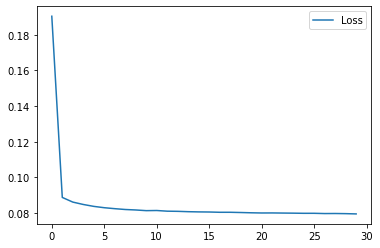

In [53]:
# plot history
plt.plot(history.history['loss'], label = 'Loss')
plt.legend()
plt.show()

### Make Prediction

In [54]:
# make a prediction
y_test_pre = model.predict(x_test)
# check length
y_test_pre.shape, y_test.shape

344/344 [==============================] - 0s 502us/step


((10995, 1), (10995,))

In [55]:
x_test.shape

(10995, 1, 21)

### Model Evaluation

In [56]:
y_test_pre

array([[1.8972566],
       [1.4967201],
       [1.4028138],
       ...,
       [1.1174878],
       [1.7516471],
       [3.0064569]], dtype=float32)

In [57]:
y_test_pre.shape

(10995, 1)

In [58]:
def RMSE(actual, prediction):
    rmse = np.sqrt(mean_squared_error(actual, prediction))
    return rmse

In [59]:
print(RMSE(y_test, y_test_pre))

0.24236852100103903


In [60]:
r2_score(y_test, y_test_pre)

0.8640175768940694

In [293]:
y_test_pre

array([[1.9076979],
       [3.2067168],
       [2.3629673],
       ...,
       [2.158131 ],
       [3.154429 ],
       [2.1941009]], dtype=float32)

## Forcasting

In [61]:
df3 = df1.reset_index()
df3.head()

tract  year  mean_rent_per  income_tax_rate  corporate_tax_rate  \
0  1003010500  2016       0.047481         0.473118            0.735294   
1  1003010500  2017       0.050942         0.473118            0.735294   
2  1003010500  2018       0.046616         0.473118            0.735294   
3  1003010500  2019       0.047697         0.473118            0.735294   
4  1003010500  2020       0.052673         0.473118            0.735294   

   state_sales_tax_rate  avg_local_sales_tax_rate  combined_rate  \
0              0.252874                       1.0         0.9124   
1              0.252874                       1.0         0.9124   
2              0.252874                       1.0         0.9124   
3              0.252874                       1.0         0.9124   
4              0.252874                       1.0         0.9124   

   max_local_sales_tax  pop_30_39  ...  real_estate3  grocery_vists_per  \
0             0.903614   0.173700  ...       0.22375           0.000687   
1             0.903614   0.174126  ...       0.33000           0.000687   
2             0.903614   0.166240  ...       0.14875           0.000687   
3             0.903614   0.198423  ...       0.00000           0.000687   
4             0.903614   0.168585  ...       0.93500           0.000687   

   hospitals_per  colleges_per  banks_per  public_schools_per  \
0       0.000585      0.000172        0.0            0.000934   
1       0.000585      0.000172        0.0            0.000934   
2       0.000585      0.000172        0.0            0.000934   
3       0.000585      0.000172        0.0            0.000934   
4       0.000585      0.000172        0.0            0.000934   

   private_schools_per  employment_rate  target_value   tract_new  
0                  0.0         0.925687      0.655000  1003010500  
1                  0.0         0.946418      0.681667  1003010500  
2                  0.0         0.948168      0.648333  1003010500  
3                  0.0         0.971024      0.656667  1003010500  
4                  0.0         0.957488      0.695000  1003010500  

[5 rows x 24 columns]

In [62]:
df3 = df3.drop(columns = ['tract_new'])

In [63]:
# normalized data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df3.drop(columns = ['tract', 'year']))
# create datefrane for scaled data
scaled_df = pd.DataFrame(data = scaled, columns = df3.drop(columns = ['tract', 'year']).columns)

In [64]:
# Put scaled_df to df1
df3[scaled_df.columns] = np.array(scaled_df)
print(df3.shape)
df3.head()

(76965, 23)


tract  year  mean_rent_per  income_tax_rate  corporate_tax_rate  \
0  1003010500  2016       0.047481         0.473118            0.735294   
1  1003010500  2017       0.050942         0.473118            0.735294   
2  1003010500  2018       0.046616         0.473118            0.735294   
3  1003010500  2019       0.047697         0.473118            0.735294   
4  1003010500  2020       0.052673         0.473118            0.735294   

   state_sales_tax_rate  avg_local_sales_tax_rate  combined_rate  \
0              0.252874                       1.0         0.9124   
1              0.252874                       1.0         0.9124   
2              0.252874                       1.0         0.9124   
3              0.252874                       1.0         0.9124   
4              0.252874                       1.0         0.9124   

   max_local_sales_tax  pop_30_39  ...     Tbill  real_estate3  \
0             0.903614   0.173700  ...  0.000000       0.22375   
1             0.903614   0.174126  ...  0.200628       0.33000   
2             0.903614   0.166240  ...  0.622564       0.14875   
3             0.903614   0.198423  ...  0.966219       0.00000   
4             0.903614   0.168585  ...  0.986574       0.93500   

   grocery_vists_per  hospitals_per  colleges_per  banks_per  \
0           0.000687       0.000585      0.000172        0.0   
1           0.000687       0.000585      0.000172        0.0   
2           0.000687       0.000585      0.000172        0.0   
3           0.000687       0.000585      0.000172        0.0   
4           0.000687       0.000585      0.000172        0.0   

   public_schools_per  private_schools_per  employment_rate  target_value  
0            0.000934                  0.0         0.925687      0.047481  
1            0.000934                  0.0         0.946418      0.050942  
2            0.000934                  0.0         0.948168      0.046616  
3            0.000934                  0.0         0.971024      0.047697  
4            0.000934                  0.0         0.957488      0.052673  

[5 rows x 23 columns]

### 2023

In [65]:
x_2020 = df3[df3['year'] == '2020'].set_index(['tract', 'year'])

In [66]:
forecast23 = x_2020.values
forecast23 = forecast23.reshape((forecast23.shape[0], 1, forecast23.shape[1]))

In [67]:
forecast23.shape

(10995, 1, 21)

In [68]:
model.predict(forecast23)

344/344 [==============================] - 0s 508us/step


array([[0.1373101 ],
       [0.12305515],
       [0.22521749],
       ...,
       [0.30924243],
       [0.2431036 ],
       [0.2583713 ]], dtype=float32)

### 2024

In [69]:
x_2021 = df3[df3['year'] == '2021'].set_index(['tract', 'year'])

In [70]:
forecast24 = x_2021.values
forecast24 = forecast24.reshape((forecast24.shape[0], 1, forecast24.shape[1]))

In [71]:
model.predict(forecast24)

344/344 [==============================] - 0s 500us/step


array([[0.18522511],
       [0.17936862],
       [0.32225904],
       ...,
       [0.29036617],
       [0.2513429 ],
       [0.2818331 ]], dtype=float32)

### 2025

In [72]:
x_2022 = df3[df3['year'] == '2022'].set_index(['tract', 'year'])

In [73]:
forecast25 = x_2022.values
forecast25 = forecast25.reshape((forecast25.shape[0], 1, forecast25.shape[1]))

In [317]:
predict2025 = model.predict(forecast25)
predict2025

344/344 [==============================] - 0s 1ms/step


array([[1.7359016],
       [1.6835089],
       [2.1973398],
       ...,
       [1.6012571],
       [1.4915296],
       [1.5754371]], dtype=float32)

In [312]:
s = df3.loc[df3['year'] == '2022', ['tract', 'target_value']].reset_index().drop('index', 1)
s.head()

tract  target_value
0  1003010500      0.694000
1  1003010600      0.670000
2  1003010704      1.424000
3  1003010707      1.428000
4  1003010708      1.213333

In [338]:
tract = df3['tract'].unique()
tract

array(['1003010500', '1003010600', '1003010704', ..., '49057210701',
       '49057211100', '49057211202'], dtype=object)

In [331]:
z = pd.DataFrame(predict2025)
z.columns = ['predict2025']
z.head()

predict2025
0     1.735902
1     1.683509
2     2.197340
3     2.228744
4     2.146394

In [342]:
z = z.assign(tract_number=tract)

In [346]:
new = s.merge(z, left_on = 'tract', right_on = 'tract_number', how = 'inner')
new.head()

tract  target_value  predict2025 tract_number
0  1003010500      0.694000     1.735902   1003010500
1  1003010600      0.670000     1.683509   1003010600
2  1003010704      1.424000     2.197340   1003010704
3  1003010707      1.428000     2.228744   1003010707
4  1003010708      1.213333     2.146394   1003010708

In [347]:
new['growth'] = (new['predict2025'] - new['target_value']) / new['target_value']
new.head()

tract  target_value  predict2025 tract_number    growth
0  1003010500      0.694000     1.735902   1003010500  1.501299
1  1003010600      0.670000     1.683509   1003010600  1.512700
2  1003010704      1.424000     2.197340   1003010704  0.543076
3  1003010707      1.428000     2.228744   1003010707  0.560745
4  1003010708      1.213333     2.146394   1003010708  0.769006

In [349]:
new.sort_values(by = 'growth', ascending = False)

tract  target_value  predict2025 tract_number    growth
5659   13215003302      0.466000     1.325366  13215003302  1.844132
185     1117030406      0.590000     1.666665   1117030406  1.824856
22      1071950602      0.620000     1.671525   1071950602  1.696009
20      1017954600      0.636000     1.676547   1017954600  1.636080
1       1003010600      0.670000     1.683509   1003010600  1.512700
0       1003010500      0.694000     1.735902   1003010500  1.501299
26      1073001500      0.688000     1.718123   1073001500  1.497272
18      1007010006      0.694000     1.728753   1007010006  1.490998
71      1073011901      0.690000     1.709558   1073011901  1.477620
8198   47157020541      0.546000     1.343615  47157020541  1.460833
70      1073011806      0.713000     1.735159   1073011806  1.433603
4980   13021011702      0.586000     1.412468  13021011702  1.410354
43      1073005200      0.740000     1.766830   1073005200  1.387609
202     1125012101      0.738000     1.756080   1125012101  1.379512
7480   40111000100      0.692000     1.636097  40111000100  1.364302
207     1125012307      0.747333     1.764635   1125012307  1.361242
7343   40037020604      0.682000     1.608867  40037020604  1.359042
65      1073011209      0.699000     1.646705   1073011209  1.355801
213     1127020302      0.781000     1.836972   1127020302  1.352077
192     1125010404      0.748000     1.746254   1125010404  1.334564
203     1125012102      0.760000     1.767646   1125012102  1.325850
8189   47157011010      0.592000     1.367318  47157011010  1.309658
159     1113030402      0.770000     1.775639   1113030402  1.306024
25      1073001200      0.778000     1.782714   1073001200  1.291406
209     1125012406      0.780000     1.785367   1125012406  1.288931
6045   22033004205      0.774000     1.769871  22033004205  1.286656
8268   47157022700      0.630000     1.437484  47157022700  1.281720
7916   47009011102      0.612000     1.393635  47009011102  1.277181
110     1081040903      0.786667     1.791224   1081040903  1.276980
7491   40125500700      0.708000     1.611129  40125500700  1.275607
129     1097003100      0.760000     1.729071   1097003100  1.275094
61      1073011004      0.792000     1.797505   1073011004  1.269577
140     1097003608      0.788000     1.782832   1097003608  1.262477
166     1115040104      0.796000     1.800590   1115040104  1.262047
6158   22121020200      0.774000     1.750450  22121020200  1.261563
7393   40109106913      0.702400     1.585005  40109106913  1.256556
6001   22033001800      0.772000     1.738445  22033001800  1.251871
5681   13215011500      0.654000     1.468292  13215011500  1.245096
23      1071950700      0.804667     1.804824   1071950700  1.242946
60      1073011002      0.802000     1.797088   1073011002  1.240758
7456   40109108403      0.724000     1.621165  40109108403  1.239178
5005   13031110500      0.610000     1.365321  13031110500  1.238232
6015   22033003702      0.774000     1.731366  22033003702  1.236907
115     1081041300      0.807000     1.800813   1081041300  1.231491
50      1073010001      0.806000     1.798040   1073010001  1.230819
5993   22033000200      0.776000     1.730256  22033000200  1.229712
818     5035030101      0.536000     1.194324   5035030101  1.228216
8265   47157022321      0.636000     1.413669  47157022321  1.222750
69      1073011805      0.816000     1.802829   1073011805  1.209350
7347   40081961700      0.718000     1.583349  40081961700  1.205221
164     1113030800      0.802000     1.763598   1113030800  1.199000
190     1125010206      0.832000     1.819060   1125010206  1.186370
206     1125012306      0.831000     1.816748   1125012306  1.186219
7425   40109107807      0.744000     1.625074  40109107807  1.184239
6049   22033004513      0.812000     1.773211  22033004513  1.183757
7390   40109106909      0.755000     1.641414  40109106909  1.174058
7590   40147000601      0.760000     1.645714  40147000601  1.165413
48      107

# Region

In [75]:
df_region.head()

index  Unnamed: 0       tract  year              id    growth  \
0      0           0  1003010500  2016  10030105002016  3.479098   
1      1           1  1003010500  2017  10030105002017  4.598007   
2      2           2  1003010500  2018  10030105002018 -5.107356   
3      3           3  1003010500  2019  10030105002019  1.017539   
4      4           4  1003010500  2020  10030105002020  5.990722   

   growth_per_sqft   mean_rent  mean_rent_per  total_units  ...  \
0         3.968254  627.083333       0.655000         68.0  ...   
1         4.071247  655.916667       0.681667         68.0  ...   
2        -4.889976  622.416667       0.648333         68.0  ...   
3         1.285347  628.750000       0.656667         68.0  ...   
4         5.837563  666.416667       0.695000         68.0  ...   

  county_female_population  county_0-19_pop  county_20-29_pop  \
0                   2858.0           1416.5             537.5   
1                   2961.0           1493.0             524.5   
2                   2806.0           1313.0             563.5   
3                   2816.0           1383.0             625.0   
4                   2764.0           1288.5             574.0   

   county_30-39_pop  county_40-49_pop county_50-59_pop  county_60-69_pop  \
0             647.5             712.0            704.0            761.50   
1             580.5             653.5            704.5            897.00   
2             530.5             661.0            703.5            867.50   
3             586.0             728.5            748.0            921.00   
4             531.5             756.5            725.5            887.25   

   county_70+_pop  employment_rate  target_value  
0          763.50         0.939210      0.655000  
1          705.50         0.956169      0.681667  
2          826.00         0.957600      0.648333  
3          852.50         0.976297      0.656667  
4          806.75         0.965224      0.695000  

[5 rows x 105 columns]

In [76]:
# Select only used columns
df_region = df_region[['tract', 'year', 'region', 'mean_rent_per', 'property_sqft', 'current_rent', 'property_value', 'income_tax_rate',
         'corporate_tax_rate', 'state_sales_tax_rate', 'avg_local_sales_tax_rate', 'combined_rate', 'max_local_sales_tax', 
         'over16_pop', 'over16_labor', 'over16_employed', 'median_income', 'avg_household_income', 'median_debt', 'population',
         'white_pop', 'black_pop', 'native_pop', 'asian_pop', 'male_population', 'pop_0_19', 'pop_20_29', 'pop_30_39', 
         'pop_40_49', 'pop_50_59', 'pop_60_69', 'occupancy_rate', 'house_supply', 'crime_rate', 'ROI_SP500', 'ROI_Tbill', 
         'ROI_Tbond', 'corp_bond', 'real_estate', 'sp500', 'Tbill', 'Tbond5', 'baa_corp_bond', 'real_estate2', 'stocks_bills', 
         'stocks_bonds', 'stocks_corp_bonds', 'hist_risk', 'inflation', 'SP500', 'Tbill_3month', 'Tbond_10year', 
         'baa_corp_bonds', 'real_estate3', 'mean_rent_scaled', 'starbucks_vists_per', 'grocery_vists_per', 'hospitals_per', 
         'colleges_per', 'banks_per', 'public_schools_per', 'private_schools_per', 'employment_rate', 'target_value']]

In [77]:
df_region.head()

tract  year region  mean_rent_per  property_sqft  current_rent  \
0  1003010500  2016      s       0.655000        65200.0         633.0   
1  1003010500  2017      s       0.681667        65200.0         633.0   
2  1003010500  2018      s       0.648333        65200.0         633.0   
3  1003010500  2019      s       0.656667        65200.0         633.0   
4  1003010500  2020      s       0.695000        65200.0         633.0   

   property_value  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
0   119546.416667         0.036667               0.065                  0.04   
1   122164.416667         0.036667               0.065                  0.04   
2   130664.500000         0.036667               0.065                  0.04   
3   140219.083333         0.036667               0.065                  0.04   
4   150638.416667         0.036667               0.065                  0.04   

   ...  mean_rent_scaled  starbucks_vists_per  grocery_vists_per  \
0  ...      42641.666667                  0.0           0.002987   
1  ...      44602.333333                  0.0           0.002987   
2  ...      42324.333333                  0.0           0.002987   
3  ...      42755.000000                  0.0           0.002987   
4  ...      45316.333333                  0.0           0.002987   

   hospitals_per  colleges_per  banks_per  public_schools_per  \
0       0.002987      0.002987        0.0            0.017921   
1       0.002987      0.002987        0.0            0.017921   
2       0.002987      0.002987        0.0            0.017921   
3       0.002987      0.002987        0.0            0.017921   
4       0.002987      0.002987        0.0            0.017921   

   private_schools_per  employment_rate  target_value  
0                  0.0         0.939210      0.655000  
1                  0.0         0.956169      0.681667  
2                  0.0         0.957600      0.648333  
3                  0.0         0.976297      0.656667  
4                  0.0         0.965224      0.695000  

[5 rows x 64 columns]

In [78]:
df_region.shape

(76965, 64)

In [79]:
df_region['region'].unique()

array(['s', 'se', 'w', 'sc', 'f', 'sw'], dtype=object)

## FL

In [80]:
fl = df_region[df_region['region'] == 'f'].reset_index().drop(columns = ['index', 'region'])
fl.head()

tract  year  mean_rent_per  property_sqft  current_rent  \
0  12001000201  2016       1.520833       159825.0        1040.0   
1  12001000201  2017       1.609167       159825.0        1040.0   
2  12001000201  2018       1.649167       159825.0        1040.0   
3  12001000201  2019       1.800833       159825.0        1040.0   
4  12001000201  2020       1.856667       159825.0        1040.0   

   property_value  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
0   130609.583333              0.0               0.055                  0.06   
1   144875.833333              0.0               0.055                  0.06   
2   159369.416667              0.0               0.055                  0.06   
3   170658.916667              0.0               0.055                  0.06   
4   182750.166667              0.0               0.055                  0.06   

   avg_local_sales_tax_rate  ...  mean_rent_scaled  starbucks_vists_per  \
0                  0.010121  ...     243131.333333             0.220751   
1                  0.010121  ...     257474.000000             0.220751   
2                  0.010121  ...     263488.666667             0.220751   
3                  0.010121  ...     287865.416667             0.220751   
4                  0.010121  ...     296916.333333             0.220751   

   grocery_vists_per  hospitals_per  colleges_per  banks_per  \
0           0.220751            0.0      0.662252        0.0   
1           0.220751            0.0      0.662252        0.0   
2           0.220751            0.0      0.662252        0.0   
3           0.220751            0.0      0.662252        0.0   
4           0.220751            0.0      0.662252        0.0   

   public_schools_per  private_schools_per  employment_rate  target_value  
0            1.324503             0.662252         0.906177      1.520833  
1            1.324503             0.662252         0.942644      1.609167  
2            1.324503             0.662252         0.916859      1.649167  
3            1.324503             0.662252         0.899006      1.800833  
4            1.324503             0.662252         0.951895      1.856667  

[5 rows x 63 columns]

### Data Standardization

In [81]:
# normalized data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(fl.drop(columns = ['tract', 'year', 'target_value']))
# create datefrane for scaled data
scaled_df = pd.DataFrame(data = scaled, columns = fl.drop(columns = ['tract', 'year', 'target_value']).columns)

In [82]:
df1 = fl.copy()

In [83]:
# Put scaled_df to df1
df1[scaled_df.columns] = np.array(scaled_df)
df1['tract_new'] = list(df1.tract)
df1.shape

(11130, 64)

In [84]:
# Set tract and year as index
df1 = df1.set_index(['tract','year'])
df1.head()

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
12001000201 2016       0.133619       0.082019      0.070203        0.071795   
            2017       0.145442       0.082019      0.070203        0.082810   
            2018       0.150795       0.082019      0.070203        0.094001   
            2019       0.171095       0.082019      0.070203        0.102718   
            2020       0.178567       0.082019      0.070203        0.112053   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
12001000201 2016              0.0                 0.0                   0.0   
            2017              0.0                 0.0                   0.0   
            2018              0.0                 0.0                   0.0   
            2019              0.0                 0.0                   0.0   
            2020              0.0                 0.0                   0.0   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
12001000201 2016                       0.0            0.0   
            2017                       0.0            0.0   
            2018                       0.0            0.0   
            2019                       0.0            0.0   
            2020                       0.0            0.0   

                  max_local_sales_tax  ...  starbucks_vists_per  \
tract       year                       ...                        
12001000201 2016                  1.0  ...             0.022075   
            2017                  1.0  ...             0.022075   
            2018                  1.0  ...             0.022075   
            2019                  1.0  ...             0.022075   
            2020                  1.0  ...             0.022075   

                  grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract       year                                                              
12001000201 2016           0.080942            0.0      0.292337        0.0   
            2017           0.080942            0.0      0.292337        0.0   
            2018           0.080942            0.0      0.292337        0.0   
            2019           0.080942            0.0      0.292337        0.0   
            2020           0.080942            0.0      0.292337        0.0   

                  public_schools_per  private_schools_per  employment_rate  \
tract       year                                                             
12001000201 2016            0.161884               0.1764         0.885306   
            2017            0.161884               0.1764         0.929885   
            2018            0.161884               0.1764         0.898363   
            2019            0.161884               0.1764         0.876539   
            2020            0.161884               0.1764         0.941194   

                  target_value    tract_new  
tract       year                             
12001000201 2016      1.520833  12001000201  
            2017      1.609167  12001000201  
            2018      1.649167  12001000201  
            2019      1.800833  12001000201  
            2020      1.856667  12001000201  

[5 rows x 62 columns]

In [85]:
df1['tract_new'].nunique()

1590

### Train-Test Split

In [86]:
# Because this is panel data so I will split each tract's data 
def train_test_split(data):
    # for train data will be collected from each tract's data which index is from 0-size (80%)
    x_train = data.drop(columns = ['target_value']).iloc[0:6] 
    # for test data will be collected from each tract's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['target_value']).iloc[3:]
    y_train = data['target_value'].iloc[0:6] 
    y_test = data['target_value'].iloc[3:] 
    return x_train, x_test, y_train, y_test

In [87]:
# get all unique tracts
tract = list(set(df1.tract_new))
# loop each tract and split the data into train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0, len(tract)):
    data = df1[df1['tract_new'] == tract[i]]
    # applied the function I created above
    x_train, x_test, y_train, y_test = train_test_split(data) 
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [88]:
X_train[0].head(10)

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
12011060603 2016       0.127038       0.348536      0.257456        0.129295   
            2017       0.129046       0.348536      0.257456        0.140244   
            2018       0.132950       0.348536      0.257456        0.151435   
            2019       0.128934       0.348536      0.257456        0.158204   
            2020       0.132504       0.348536      0.257456        0.164485   
            2021       0.170760       0.348536      0.257456        0.189954   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
12011060603 2016              0.0                 0.0                   0.0   
            2017              0.0                 0.0                   0.0   
            2018              0.0                 0.0                   0.0   
            2019              0.0                 0.0                   0.0   
            2020              0.0                 0.0                   0.0   
            2021              0.0                 0.0                   0.0   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
12011060603 2016                       0.0            0.0   
            2017                       0.0            0.0   
            2018                       0.0            0.0   
            2019                       0.0            0.0   
            2020                       0.0            0.0   
            2021                       0.0            0.0   

                  max_local_sales_tax  ...  mean_rent_scaled  \
tract       year                       ...                     
12011060603 2016                  1.0  ...          0.248694   
            2017                  1.0  ...          0.251261   
            2018                  1.0  ...          0.256034   
            2019                  1.0  ...          0.250936   
            2020                  1.0  ...          0.255937   
            2021                  1.0  ...          0.305446   

                  starbucks_vists_per  grocery_vists_per  hospitals_per  \
tract       year                                                          
12011060603 2016                  0.0           0.199059       0.031053   
            2017                  0.0           0.199059       0.031053   
            2018                  0.0           0.199059       0.031053   
            2019                  0.0           0.199059       0.031053   
            2020                  0.0           0.199059       0.031053   
            2021                  0.0           0.199059       0.031053   

                  colleges_per  banks_per  public_schools_per  \
tract       year                                                
12011060603 2016           0.0   0.015508            0.053082   
            2017           0.0   0.015508            0.053082   
            2018           0.0   0.015508            0.053082   
            2019           0.0   0.015508            0.053082   
            2020           0.0   0.015508            0.053082   
            2021           0.0   0.015508            0.053082   

                  private_schools_per  employment_rate    tract_new  
tract       year                                                     
12011060603 2016             0.144606         0.916699  12011060603  
            2017             0.144606         0.914122  12011060603  
            2018             0.144606         0.901937  12011060603  
            2019             0.144606         0.889230  12011060603  
            2020             0.144606         0.906824  12011060603  
            2021             0.144606         0.911543  12011060603  

[6 rows x 61 columns]

In [89]:
Y_test[0].head(10)

tract        year
12011060603  2019    1.485833
             2020    1.512500
             2021    1.798333
             2022    2.048000
Name: target_value, dtype: float64

In [90]:
# concatenate each train dataset in X_train list and Y_train list respectively 
X_train = pd.concat(X_train)
Y_train = pd.DataFrame(pd.concat(Y_train))
# concatenate each test dataset in X_test list and Y_test list respectively
X_test = pd.concat(X_test)
Y_test = pd.DataFrame(pd.concat(Y_test))

In [91]:
# double check the train data and test data and our target 
X_train.head()

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
12011060603 2016       0.127038       0.348536      0.257456        0.129295   
            2017       0.129046       0.348536      0.257456        0.140244   
            2018       0.132950       0.348536      0.257456        0.151435   
            2019       0.128934       0.348536      0.257456        0.158204   
            2020       0.132504       0.348536      0.257456        0.164485   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
12011060603 2016              0.0                 0.0                   0.0   
            2017              0.0                 0.0                   0.0   
            2018              0.0                 0.0                   0.0   
            2019              0.0                 0.0                   0.0   
            2020              0.0                 0.0                   0.0   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
12011060603 2016                       0.0            0.0   
            2017                       0.0            0.0   
            2018                       0.0            0.0   
            2019                       0.0            0.0   
            2020                       0.0            0.0   

                  max_local_sales_tax  ...  mean_rent_scaled  \
tract       year                       ...                     
12011060603 2016                  1.0  ...          0.248694   
            2017                  1.0  ...          0.251261   
            2018                  1.0  ...          0.256034   
            2019                  1.0  ...          0.250936   
            2020                  1.0  ...          0.255937   

                  starbucks_vists_per  grocery_vists_per  hospitals_per  \
tract       year                                                          
12011060603 2016                  0.0           0.199059       0.031053   
            2017                  0.0           0.199059       0.031053   
            2018                  0.0           0.199059       0.031053   
            2019                  0.0           0.199059       0.031053   
            2020                  0.0           0.199059       0.031053   

                  colleges_per  banks_per  public_schools_per  \
tract       year                                                
12011060603 2016           0.0   0.015508            0.053082   
            2017           0.0   0.015508            0.053082   
            2018           0.0   0.015508            0.053082   
            2019           0.0   0.015508            0.053082   
            2020           0.0   0.015508            0.053082   

                  private_schools_per  employment_rate    tract_new  
tract       year                                                     
12011060603 2016             0.144606         0.916699  12011060603  
            2017             0.144606         0.914122  12011060603  
            2018             0.144606         0.901937  12011060603  
            2019             0.144606         0.889230  12011060603  
            2020             0.144606         0.906824  12011060603  

[5 rows x 61 columns]

In [92]:
X_train.shape

(9540, 61)

In [93]:
X_train['tract_new'].nunique() * 6

9540

### Data Preprocessing

In [94]:
#combine X train and Y train as train data 
train_data = pd.DataFrame()
train_data[X_train.columns] = X_train
train_data[Y_train.columns] = Y_train
#combine X test and Y test as test data 
test_data = pd.DataFrame()
test_data[X_test.columns] = X_test
test_data[Y_test.columns] = Y_test

In [95]:
train_data.head(10)

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
12011060603 2016       0.127038       0.348536      0.257456        0.129295   
            2017       0.129046       0.348536      0.257456        0.140244   
            2018       0.132950       0.348536      0.257456        0.151435   
            2019       0.128934       0.348536      0.257456        0.158204   
            2020       0.132504       0.348536      0.257456        0.164485   
            2021       0.170760       0.348536      0.257456        0.189954   
12073001601 2016       0.040273       0.098371      0.073860        0.132842   
            2017       0.041268       0.098371      0.073860        0.142283   
            2018       0.048119       0.098371      0.073860        0.151509   
            2019       0.053377       0.098371      0.073860        0.157347   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
12011060603 2016              0.0                 0.0                   0.0   
            2017              0.0                 0.0                   0.0   
            2018              0.0                 0.0                   0.0   
            2019              0.0                 0.0                   0.0   
            2020              0.0                 0.0                   0.0   
            2021              0.0                 0.0                   0.0   
12073001601 2016              0.0                 0.0                   0.0   
            2017              0.0                 0.0                   0.0   
            2018              0.0                 0.0                   0.0   
            2019              0.0                 0.0                   0.0   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
12011060603 2016                       0.0            0.0   
            2017                       0.0            0.0   
            2018                       0.0            0.0   
            2019                       0.0            0.0   
            2020                       0.0            0.0   
            2021                       0.0            0.0   
12073001601 2016                       0.0            0.0   
            2017                       0.0            0.0   
            2018                       0.0            0.0   
            2019                       0.0            0.0   

                  max_local_sales_tax  ...  starbucks_vists_per  \
tract       year                       ...                        
12011060603 2016                  1.0  ...             0.000000   
            2017                  1.0  ...             0.000000   
            2018                  1.0  ...             0.000000   
            2019                  1.0  ...             0.000000   
            2020                  1.0  ...             0.000000   
            2021                  1.0  ...             0.000000   
12073001601 2016                  1.0  ...             0.004202   
            2017                  1.0  ...             0.004202   
            2018                  1.0  ...             0.004202   
            2019                  1.0  ...             0.004202   

                  grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract       year                                                              
12011060603 2016           0.199059       0.031053      0.000000   0.015508   
            2017           0.199059       0.031053      0.000000   0.015508   
            2018           0.199059       0.031053      0.000000   0.015508   
            2019           0.199059       0.031053      0.000000   0.015508   
            2020           0.199059       0.031053      0.000000   0.015508   
            2021 

In [96]:
test_data.head(10)

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
12011060603 2019       0.128934       0.348536      0.257456        0.158204   
            2020       0.132504       0.348536      0.257456        0.164485   
            2021       0.170760       0.348536      0.257456        0.189954   
            2022       0.204176       0.348536      0.257456        0.223314   
12073001601 2019       0.053377       0.098371      0.073860        0.157347   
            2020       0.056006       0.098371      0.073860        0.164617   
            2021       0.064547       0.098371      0.073860        0.191876   
            2022       0.077676       0.098371      0.073860        0.217297   
12081002025 2019       0.072832       0.312081      0.247163        0.246030   
            2020       0.070379       0.312081      0.247163        0.254179   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
12011060603 2019              0.0                 0.0                   0.0   
            2020              0.0                 0.0                   0.0   
            2021              0.0                 0.0                   0.0   
            2022              0.0                 0.0                   0.0   
12073001601 2019              0.0                 0.0                   0.0   
            2020              0.0                 0.0                   0.0   
            2021              0.0                 0.0                   0.0   
            2022              0.0                 0.0                   0.0   
12081002025 2019              0.0                 0.0                   0.0   
            2020              0.0                 0.0                   0.0   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
12011060603 2019                       0.0            0.0   
            2020                       0.0            0.0   
            2021                       0.0            0.0   
            2022                       0.0            0.0   
12073001601 2019                       0.0            0.0   
            2020                       0.0            0.0   
            2021                       0.0            0.0   
            2022                       0.0            0.0   
12081002025 2019                       0.0            0.0   
            2020                       0.0            0.0   

                  max_local_sales_tax  ...  starbucks_vists_per  \
tract       year                       ...                        
12011060603 2019                  1.0  ...             0.000000   
            2020                  1.0  ...             0.000000   
            2021                  1.0  ...             0.000000   
            2022                  1.0  ...             0.000000   
12073001601 2019                  1.0  ...             0.004202   
            2020                  1.0  ...             0.004202   
            2021                  1.0  ...             0.004202   
            2022                  1.0  ...             0.004202   
12081002025 2019                  1.0  ...             0.000000   
            2020                  1.0  ...             0.000000   

                  grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract       year                                                              
12011060603 2019           0.199059       0.031053      0.000000   0.015508   
            2020           0.199059       0.031053      0.000000   0.015508   
            2021           0.199059       0.031053      0.000000   0.015508   
            2022           0.199059       0.031053      0.000000   0.015508   
12073001601 2019           0.009104       0.000000      0.005902   0.000000   
            2020 

In [97]:
# Code Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning
def series_to_supervised(data, n_in = 0, n_out = -3, dropnan = True):
    df2 = pd.DataFrame(data)
    tract = list(set(df2['tract_new']))
    agg = pd.DataFrame()
    for i in range(0, len(tract)):
        each_tract = df2[df2['tract_new'] == tract[i]]
        cols = []
        agg1 = pd.DataFrame()
    # input sequence (t-n, ... t-1)
        cols.append(each_tract.shift(n_in))
    # forecast sequence (t, t+1, ... t+n)
        cols.append(each_tract.shift(n_out))
        agg1 = pd.concat(cols, axis = 1)
        agg = agg.append(agg1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

In [98]:
# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except
    reframed_train = series_to_supervised(train).drop(columns = ['tract_new'])
    reframed_test = series_to_supervised(test).drop(columns = ['tract_new'])
    names = df1.columns.to_list()
    names.remove('tract_new')
    present = []
    future = []
    for i in names:
        present.append(i)
        future.append(f'{i}_t+3')
    names = present + future
    reframed_train.columns = names
    reframed_test.columns = names
    # split into train and test sets
    train = reframed_train.values
    test = reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :21], train[:, -1]
    test_X, y_test = test[:, :21], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test

In [99]:
# using the function to obtian reshaped x_train,x_test,y_train,y_test
x_train, x_test, y_train, y_test = reshape_data(train_data, test_data)

In [100]:
x_test.shape

(1590, 1, 21)

In [101]:
x_train.shape

(4770, 1, 21)

### Model: LSTM

In [102]:
# def create_model():
#     # create model
#     model = Sequential()
#     model.add(LSTM(60, activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[2])))
#     model.add(Dense(1))
#     model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])
#     return model

In [103]:
# # Create the model
# model = KerasRegressor(build_fn = create_model, verbose = 0)
# # Define the grid search parameters
# batch_size = [10,20,40]
# epochs = [10,50,100]
# # Make a dictionary of the grid search parameters
# param_grid = dict(batch_size = batch_size, epochs = epochs)
# # Build and fit the GridSearchCV
# grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(), verbose = 10)
# grid_result = grid.fit(x_train, y_train)

In [104]:
# print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#   print('{},{} with: {}'.format(mean, stdev, param))

In [105]:
model = Sequential()
model.add(LSTM(60, activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])

In [106]:
# fit network
history = model.fit(x_train, y_train, epochs = 30, batch_size = 50,  verbose = 1, shuffle = False)

Epoch 1/30
96/96 [==============================] - 1s 873us/step - loss: 0.9203 - accuracy: 2.0964e-04
Epoch 2/30
96/96 [==============================] - 0s 853us/step - loss: 0.2764 - accuracy: 2.0964e-04
Epoch 3/30
96/96 [==============================] - 0s 874us/step - loss: 0.2387 - accuracy: 2.0964e-04
Epoch 4/30
96/96 [==============================] - 0s 890us/step - loss: 0.2039 - accuracy: 2.0964e-04
Epoch 5/30
96/96 [==============================] - 0s 919us/step - loss: 0.1808 - accuracy: 2.0964e-04
Epoch 6/30
96/96 [==============================] - 0s 884us/step - loss: 0.1654 - accuracy: 2.0964e-04
Epoch 7/30
96/96 [==============================] - 0s 849us/step - loss: 0.1525 - accuracy: 2.0964e-04
Epoch 8/30
96/96 [==============================] - 0s 853us/step - loss: 0.1417 - accuracy: 2.0964e-04
Epoch 9/30
96/96 [==============================] - 0s 833us/step - loss: 0.1330 - accuracy: 2.0964e-04
Epoch 10/30
96/96 [==============================] - 0s 843us/st

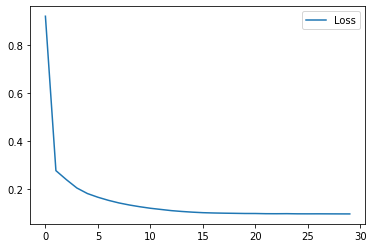

In [107]:
# plot history
plt.plot(history.history['loss'], label = 'Loss')
plt.legend()
plt.show()

#### Make Prediction

In [108]:
# make a prediction
y_test_pre = model.predict(x_test)
# check length
y_test_pre.shape, y_test.shape

50/50 [==============================] - 0s 661us/step


((1590, 1), (1590,))

In [109]:
x_test.shape

(1590, 1, 21)

#### Model Evaluation

In [110]:
y_test_pre

array([[1.5603038],
       [1.0689247],
       [1.1721901],
       ...,
       [1.6661446],
       [1.4383261],
       [1.379459 ]], dtype=float32)

In [111]:
y_test_pre.shape

(1590, 1)

In [112]:
def RMSE(actual, prediction):
    rmse = np.sqrt(mean_squared_error(actual, prediction))
    return rmse

In [113]:
print(RMSE(y_test, y_test_pre))

0.3904360464303458


In [114]:
r2_score(y_test, y_test_pre)

0.37082174516046384

## SE

In [115]:
se = df_region[df_region['region'] == 'se'].reset_index().drop(columns = ['index', 'region'])
se.head()

tract  year  mean_rent_per  property_sqft  current_rent  \
0  1017954300  2016       0.937917       438609.0        1181.5   
1  1017954300  2017       0.699167       438609.0        1181.5   
2  1017954300  2018       0.705000       438609.0        1181.5   
3  1017954300  2019       0.730417       438609.0        1181.5   
4  1017954300  2020       0.809167       438609.0        1181.5   

   property_value  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
0    80781.750000         0.036667               0.065                  0.04   
1    83870.250000         0.036667               0.065                  0.04   
2    86761.583333         0.036667               0.065                  0.04   
3    91361.250000         0.036667               0.065                  0.04   
4    95653.000000         0.036667               0.065                  0.04   

   avg_local_sales_tax_rate  ...  mean_rent_scaled  starbucks_vists_per  \
0                  0.052386  ...     407768.666667                  0.0   
1                  0.052386  ...     305155.375000                  0.0   
2                  0.052386  ...     307581.750000                  0.0   
3                  0.052386  ...     318388.583333                  0.0   
4                  0.052386  ...     353269.875000                  0.0   

   grocery_vists_per  hospitals_per  colleges_per  banks_per  \
0                0.0       0.016987           0.0        0.0   
1                0.0       0.016987           0.0        0.0   
2                0.0       0.016987           0.0        0.0   
3                0.0       0.016987           0.0        0.0   
4                0.0       0.016987           0.0        0.0   

   public_schools_per  private_schools_per  employment_rate  target_value  
0            0.118906             0.033973         0.949264      0.937917  
1            0.118906             0.033973         0.964539      0.699167  
2            0.118906             0.033973         0.961360      0.705000  
3            0.118906             0.033973         0.973101      0.730417  
4            0.118906             0.033973         0.976796      0.809167  

[5 rows x 63 columns]

### Data Standardization

In [116]:
# normalized data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(se.drop(columns = ['tract', 'year', 'target_value']))
# create datefrane for scaled data
scaled_df = pd.DataFrame(data = scaled, columns = se.drop(columns = ['tract', 'year', 'target_value']).columns)

In [117]:
df1 = se.copy()

In [118]:
# Put scaled_df to df1
df1[scaled_df.columns] = np.array(scaled_df)
df1['tract_new'] = list(df1.tract)
df1.shape

(11767, 64)

In [119]:
# Set tract and year as index
df1 = df1.set_index(['tract','year'])
df1.head()

mean_rent_per  property_sqft  current_rent  property_value  \
tract      year                                                               
1017954300 2016       0.224029       0.385985      0.214549        0.042174   
           2017       0.141583       0.385985      0.214549        0.044481   
           2018       0.143597       0.385985      0.214549        0.046639   
           2019       0.152374       0.385985      0.214549        0.050074   
           2020       0.179568       0.385985      0.214549        0.053278   

                 income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract      year                                                              
1017954300 2016         0.136017                 1.0          5.107026e-15   
           2017         0.136017                 1.0          5.107026e-15   
           2018         0.136017                 1.0          5.107026e-15   
           2019         0.136017                 1.0          5.107026e-15   
           2020         0.136017                 1.0          5.107026e-15   

                 avg_local_sales_tax_rate  combined_rate  max_local_sales_tax  \
tract      year                                                                 
1017954300 2016                       1.0            1.0                  1.0   
           2017                       1.0            1.0                  1.0   
           2018                       1.0            1.0                  1.0   
           2019                       1.0            1.0                  1.0   
           2020                       1.0            1.0                  1.0   

                 ...  starbucks_vists_per  grocery_vists_per  hospitals_per  \
tract      year  ...                                                          
1017954300 2016  ...                  0.0                0.0       0.011169   
           2017  ...                  0.0                0.0       0.011169   
           2018  ...                  0.0                0.0       0.011169   
           2019  ...                  0.0                0.0       0.011169   
           2020  ...                  0.0                0.0       0.011169   

                 colleges_per  banks_per  public_schools_per  \
tract      year                                                
1017954300 2016           0.0        0.0            0.039239   
           2017           0.0        0.0            0.039239   
           2018           0.0        0.0            0.039239   
           2019           0.0        0.0            0.039239   
           2020           0.0        0.0            0.039239   

                 private_schools_per  employment_rate  target_value  \
tract      year                                                       
1017954300 2016             0.016709         0.924479      0.937917   
           2017             0.016709         0.947216      0.699167   
           2018             0.016709         0.942484      0.705000   
           2019             0.016709         0.959960      0.730417   
           2020             0.016709         0.965460      0.809167   

                  tract_new  
tract      year              
1017954300 2016  1017954300  
           2017  1017954300  
           2018  1017954300  
           2019  1017954300  
           2020  1017954300  

[5 rows x 62 columns]

In [120]:
df1['tract_new'].nunique()

1681

### Train-Test Split

In [121]:
# Because this is panel data so I will split each tract's data 
def train_test_split(data):
    # for train data will be collected from each tract's data which index is from 0-size (80%)
    x_train = data.drop(columns = ['target_value']).iloc[0:6] 
    # for test data will be collected from each tract's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['target_value']).iloc[3:]
    y_train = data['target_value'].iloc[0:6] 
    y_test = data['target_value'].iloc[3:] 
    return x_train, x_test, y_train, y_test

In [122]:
# get all unique tracts
tract = list(set(df1.tract_new))
# loop each tract and split the data into train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0, len(tract)):
    data = df1[df1['tract_new'] == tract[i]]
    # applied the function I created above
    x_train, x_test, y_train, y_test = train_test_split(data) 
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [123]:
X_train[0].head(10)

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
13057090905 2016       0.276835       0.490247      0.416903        0.151114   
            2017       0.279137       0.490247      0.416903        0.160263   
            2018       0.307338       0.490247      0.416903        0.174557   
            2019       0.316547       0.490247      0.416903        0.187317   
            2020       0.326043       0.490247      0.416903        0.197835   
            2021       0.420144       0.490247      0.416903        0.237797   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
13057090905 2016              0.0              0.8125          5.107026e-15   
            2017              0.0              0.8125          5.107026e-15   
            2018              0.0              0.8125          5.107026e-15   
            2019              0.0              0.8125          5.107026e-15   
            2020              0.0              0.8125          5.107026e-15   
            2021              0.0              0.8125          5.107026e-15   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
13057090905 2016                   0.50238       0.161232   
            2017                   0.50238       0.161232   
            2018                   0.50238       0.161232   
            2019                   0.50238       0.161232   
            2020                   0.50238       0.161232   
            2021                   0.50238       0.161232   

                  max_local_sales_tax  ...  mean_rent_scaled  \
tract       year                       ...                     
13057090905 2016             0.452632  ...          0.335198   
            2017             0.452632  ...          0.337205   
            2018             0.452632  ...          0.363417   
            2019             0.452632  ...          0.371756   
            2020             0.452632  ...          0.380883   
            2021             0.452632  ...          0.466854   

                  starbucks_vists_per  grocery_vists_per  hospitals_per  \
tract       year                                                          
13057090905 2016             0.008967           0.031385            0.0   
            2017             0.008967           0.031385            0.0   
            2018             0.008967           0.031385            0.0   
            2019             0.008967           0.031385            0.0   
            2020             0.008967           0.031385            0.0   
            2021             0.008967           0.031385            0.0   

                  colleges_per  banks_per  public_schools_per  \
tract       year                                                
13057090905 2016           0.0        0.0            0.052536   
            2017           0.0        0.0            0.052536   
            2018           0.0        0.0            0.052536   
            2019           0.0        0.0            0.052536   
            2020           0.0        0.0            0.052536   
            2021           0.0        0.0            0.052536   

                  private_schools_per  employment_rate    tract_new  
tract       year                                                     
13057090905 2016             0.067112         0.935368  13057090905  
            2017             0.067112         0.884124  13057090905  
            2018             0.067112         0.911003  13057090905  
            2019             0.067112         0.900222  13057090905  
            2020             0.067112         0.876248  13057090905  
            2021             0.067112         0.899234  13057090905  

[6 rows x 61 columns]

In [124]:
Y_test[0].head(10)

tract        year
13057090905  2019    1.205833
             2020    1.233333
             2021    1.505833
             2022    1.660000
Name: target_value, dtype: float64

In [125]:
# concatenate each train dataset in X_train list and Y_train list respectively 
X_train = pd.concat(X_train)
Y_train = pd.DataFrame(pd.concat(Y_train))
# concatenate each test dataset in X_test list and Y_test list respectively
X_test = pd.concat(X_test)
Y_test = pd.DataFrame(pd.concat(Y_test))

In [126]:
# double check the train data and test data and our target 
X_train.head()

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
13057090905 2016       0.276835       0.490247      0.416903        0.151114   
            2017       0.279137       0.490247      0.416903        0.160263   
            2018       0.307338       0.490247      0.416903        0.174557   
            2019       0.316547       0.490247      0.416903        0.187317   
            2020       0.326043       0.490247      0.416903        0.197835   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
13057090905 2016              0.0              0.8125          5.107026e-15   
            2017              0.0              0.8125          5.107026e-15   
            2018              0.0              0.8125          5.107026e-15   
            2019              0.0              0.8125          5.107026e-15   
            2020              0.0              0.8125          5.107026e-15   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
13057090905 2016                   0.50238       0.161232   
            2017                   0.50238       0.161232   
            2018                   0.50238       0.161232   
            2019                   0.50238       0.161232   
            2020                   0.50238       0.161232   

                  max_local_sales_tax  ...  mean_rent_scaled  \
tract       year                       ...                     
13057090905 2016             0.452632  ...          0.335198   
            2017             0.452632  ...          0.337205   
            2018             0.452632  ...          0.363417   
            2019             0.452632  ...          0.371756   
            2020             0.452632  ...          0.380883   

                  starbucks_vists_per  grocery_vists_per  hospitals_per  \
tract       year                                                          
13057090905 2016             0.008967           0.031385            0.0   
            2017             0.008967           0.031385            0.0   
            2018             0.008967           0.031385            0.0   
            2019             0.008967           0.031385            0.0   
            2020             0.008967           0.031385            0.0   

                  colleges_per  banks_per  public_schools_per  \
tract       year                                                
13057090905 2016           0.0        0.0            0.052536   
            2017           0.0        0.0            0.052536   
            2018           0.0        0.0            0.052536   
            2019           0.0        0.0            0.052536   
            2020           0.0        0.0            0.052536   

                  private_schools_per  employment_rate    tract_new  
tract       year                                                     
13057090905 2016             0.067112         0.935368  13057090905  
            2017             0.067112         0.884124  13057090905  
            2018             0.067112         0.911003  13057090905  
            2019             0.067112         0.900222  13057090905  
            2020             0.067112         0.876248  13057090905  

[5 rows x 61 columns]

In [127]:
X_train.shape

(10086, 61)

In [128]:
X_train['tract_new'].nunique() * 6

10086

### Data Preprocessing

In [129]:
#combine X train and Y train as train data 
train_data = pd.DataFrame()
train_data[X_train.columns] = X_train
train_data[Y_train.columns] = Y_train
#combine X test and Y test as test data 
test_data = pd.DataFrame()
test_data[X_test.columns] = X_test
test_data[Y_test.columns] = Y_test

In [130]:
train_data.head(10)

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
13057090905 2016       0.276835       0.490247      0.416903        0.151114   
            2017       0.279137       0.490247      0.416903        0.160263   
            2018       0.307338       0.490247      0.416903        0.174557   
            2019       0.316547       0.490247      0.416903        0.187317   
            2020       0.326043       0.490247      0.416903        0.197835   
            2021       0.420144       0.490247      0.416903        0.237797   
37119006211 2016       0.264460       0.280077      0.324447        0.192137   
            2017       0.257266       0.280077      0.324447        0.204937   
            2018       0.273669       0.280077      0.324447        0.217060   
            2019       0.287482       0.280077      0.324447        0.224117   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
13057090905 2016              0.0        8.125000e-01          5.107026e-15   
            2017              0.0        8.125000e-01          5.107026e-15   
            2018              0.0        8.125000e-01          5.107026e-15   
            2019              0.0        8.125000e-01          5.107026e-15   
            2020              0.0        8.125000e-01          5.107026e-15   
            2021              0.0        8.125000e-01          5.107026e-15   
37119006211 2016              1.0        2.553513e-15          3.750000e-01   
            2017              1.0        2.553513e-15          3.750000e-01   
            2018              1.0        2.553513e-15          3.750000e-01   
            2019              1.0        2.553513e-15          3.750000e-01   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
13057090905 2016                  0.502380       0.161232   
            2017                  0.502380       0.161232   
            2018                  0.502380       0.161232   
            2019                  0.502380       0.161232   
            2020                  0.502380       0.161232   
            2021                  0.502380       0.161232   
37119006211 2016                  0.209301       0.000000   
            2017                  0.209301       0.000000   
            2018                  0.209301       0.000000   
            2019                  0.209301       0.000000   

                  max_local_sales_tax  ...  starbucks_vists_per  \
tract       year                       ...                        
13057090905 2016             0.452632  ...             0.008967   
            2017             0.452632  ...             0.008967   
            2018             0.452632  ...             0.008967   
            2019             0.452632  ...             0.008967   
            2020             0.452632  ...             0.008967   
            2021             0.452632  ...             0.008967   
37119006211 2016             0.000000  ...             0.004635   
            2017             0.000000  ...             0.004635   
            2018             0.000000  ...             0.004635   
            2019             0.000000  ...             0.004635   

                  grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract       year                                                              
13057090905 2016           0.031385       0.000000           0.0        0.0   
            2017           0.031385       0.000000           0.0        0.0   
            2018           0.031385       0.000000           0.0        0.0   
            2019           0.031385       0.000000           0.0        0.0   
            2020           0.031385       0.000000           0.0        0.0   
            2021 

In [131]:
test_data.head(10)

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
13057090905 2019       0.316547       0.490247      0.416903        0.187317   
            2020       0.326043       0.490247      0.416903        0.197835   
            2021       0.420144       0.490247      0.416903        0.237797   
            2022       0.473381       0.490247      0.416903        0.284630   
37119006211 2019       0.287482       0.280077      0.324447        0.224117   
            2020       0.321439       0.280077      0.324447        0.235379   
            2021       0.386475       0.280077      0.324447        0.281622   
            2022       0.393957       0.280077      0.324447        0.335382   
13135050745 2019       0.315683       0.384119      0.410380        0.186078   
            2020       0.383885       0.280591      0.402864        0.196665   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
13057090905 2019              0.0        8.125000e-01          5.107026e-15   
            2020              0.0        8.125000e-01          5.107026e-15   
            2021              0.0        8.125000e-01          5.107026e-15   
            2022              0.0        8.125000e-01          5.107026e-15   
37119006211 2019              1.0        2.553513e-15          3.750000e-01   
            2020              1.0        2.553513e-15          3.750000e-01   
            2021              1.0        2.553513e-15          3.750000e-01   
            2022              1.0        2.553513e-15          3.750000e-01   
13135050745 2019              0.0        8.125000e-01          5.107026e-15   
            2020              0.0        8.125000e-01          5.107026e-15   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
13057090905 2019                  0.502380       0.161232   
            2020                  0.502380       0.161232   
            2021                  0.502380       0.161232   
            2022                  0.502380       0.161232   
37119006211 2019                  0.209301       0.000000   
            2020                  0.209301       0.000000   
            2021                  0.209301       0.000000   
            2022                  0.209301       0.000000   
13135050745 2019                  0.502380       0.161232   
            2020                  0.502380       0.161232   

                  max_local_sales_tax  ...  starbucks_vists_per  \
tract       year                       ...                        
13057090905 2019             0.452632  ...             0.008967   
            2020             0.452632  ...             0.008967   
            2021             0.452632  ...             0.008967   
            2022             0.452632  ...             0.008967   
37119006211 2019             0.000000  ...             0.004635   
            2020             0.000000  ...             0.004635   
            2021             0.000000  ...             0.004635   
            2022             0.000000  ...             0.004635   
13135050745 2019             0.452632  ...             0.000000   
            2020             0.452632  ...             0.000000   

                  grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract       year                                                              
13057090905 2019           0.031385       0.000000           0.0        0.0   
            2020           0.031385       0.000000           0.0        0.0   
            2021           0.031385       0.000000           0.0        0.0   
            2022           0.031385       0.000000           0.0        0.0   
37119006211 2019           0.018025       0.010306           0.0        0.0   
            2020 

In [132]:
# Code Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning
def series_to_supervised(data, n_in = 0, n_out = -3, dropnan = True):
    df2 = pd.DataFrame(data)
    tract = list(set(df2['tract_new']))
    agg = pd.DataFrame()
    for i in range(0, len(tract)):
        each_tract = df2[df2['tract_new'] == tract[i]]
        cols = []
        agg1 = pd.DataFrame()
    # input sequence (t-n, ... t-1)
        cols.append(each_tract.shift(n_in))
    # forecast sequence (t, t+1, ... t+n)
        cols.append(each_tract.shift(n_out))
        agg1 = pd.concat(cols, axis = 1)
        agg = agg.append(agg1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

In [133]:
# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except
    reframed_train = series_to_supervised(train).drop(columns = ['tract_new'])
    reframed_test = series_to_supervised(test).drop(columns = ['tract_new'])
    names = df1.columns.to_list()
    names.remove('tract_new')
    present = []
    future = []
    for i in names:
        present.append(i)
        future.append(f'{i}_t+3')
    names = present + future
    reframed_train.columns = names
    reframed_test.columns = names
    # split into train and test sets
    train = reframed_train.values
    test = reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :21], train[:, -1]
    test_X, y_test = test[:, :21], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test

In [134]:
# using the function to obtian reshaped x_train,x_test,y_train,y_test
x_train, x_test, y_train, y_test = reshape_data(train_data, test_data)

In [135]:
x_test.shape

(1681, 1, 21)

In [136]:
x_train.shape

(5043, 1, 21)

### Model: LSTM

In [137]:
# def create_model():
#     # create model
#     model = Sequential()
#     model.add(LSTM(60, activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[2])))
#     model.add(Dense(1))
#     model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])
#     return model

In [138]:
# # Create the model
# model = KerasRegressor(build_fn = create_model, verbose = 0)
# # Define the grid search parameters
# batch_size = [10,20,40]
# epochs = [10,50,100]
# # Make a dictionary of the grid search parameters
# param_grid = dict(batch_size = batch_size, epochs = epochs)
# # Build and fit the GridSearchCV
# grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(), verbose = 10)
# grid_result = grid.fit(x_train, y_train)

In [139]:
# print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#   print('{},{} with: {}'.format(mean, stdev, param))

In [140]:
model = Sequential()
model.add(LSTM(60, activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])

In [141]:
# fit network
history = model.fit(x_train, y_train, epochs = 30, batch_size = 50,  verbose = 1, shuffle = False)

Epoch 1/30
101/101 [==============================] - 1s 825us/step - loss: 0.6213 - accuracy: 0.0014
Epoch 2/30
101/101 [==============================] - 0s 851us/step - loss: 0.1793 - accuracy: 0.0016
Epoch 3/30
101/101 [==============================] - 0s 844us/step - loss: 0.1491 - accuracy: 0.0016
Epoch 4/30
101/101 [==============================] - 0s 852us/step - loss: 0.1242 - accuracy: 0.0016
Epoch 5/30
101/101 [==============================] - 0s 849us/step - loss: 0.1043 - accuracy: 0.0016
Epoch 6/30
101/101 [==============================] - 0s 846us/step - loss: 0.0902 - accuracy: 0.0016
Epoch 7/30
101/101 [==============================] - 0s 854us/step - loss: 0.0834 - accuracy: 0.0016
Epoch 8/30
101/101 [==============================] - 0s 822us/step - loss: 0.0802 - accuracy: 0.0016
Epoch 9/30
101/101 [==============================] - 0s 847us/step - loss: 0.0784 - accuracy: 0.0016
Epoch 10/30
101/101 [==============================] - 0s 855us/step - loss: 0.077

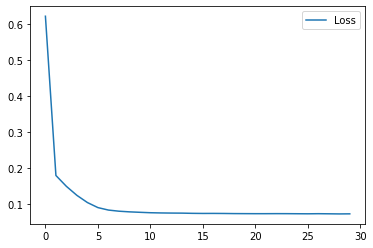

In [142]:
# plot history
plt.plot(history.history['loss'], label = 'Loss')
plt.legend()
plt.show()

#### Make Prediction

In [143]:
# make a prediction
y_test_pre = model.predict(x_test)
# check length
y_test_pre.shape, y_test.shape

53/53 [==============================] - 0s 804us/step


((1681, 1), (1681,))

In [144]:
x_test.shape

(1681, 1, 21)

#### Model Evaluation

In [145]:
y_test_pre

array([[1.3372083],
       [1.2687198],
       [1.4059564],
       ...,
       [1.1025628],
       [1.7092277],
       [1.0702156]], dtype=float32)

In [146]:
y_test_pre.shape

(1681, 1)

In [147]:
def RMSE(actual, prediction):
    rmse = np.sqrt(mean_squared_error(actual, prediction))
    return rmse

In [148]:
print(RMSE(y_test, y_test_pre))

0.2027141834846857


In [149]:
r2_score(y_test, y_test_pre)

0.6815472282546485

## S

In [150]:
s = df_region[df_region['region'] == 's'].reset_index().drop(columns = ['index', 'region'])
s.head()

tract  year  mean_rent_per  property_sqft  current_rent  \
0  1003010500  2016       0.655000        65200.0         633.0   
1  1003010500  2017       0.681667        65200.0         633.0   
2  1003010500  2018       0.648333        65200.0         633.0   
3  1003010500  2019       0.656667        65200.0         633.0   
4  1003010500  2020       0.695000        65200.0         633.0   

   property_value  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
0   119546.416667         0.036667               0.065                  0.04   
1   122164.416667         0.036667               0.065                  0.04   
2   130664.500000         0.036667               0.065                  0.04   
3   140219.083333         0.036667               0.065                  0.04   
4   150638.416667         0.036667               0.065                  0.04   

   avg_local_sales_tax_rate  ...  mean_rent_scaled  starbucks_vists_per  \
0                  0.052386  ...      42641.666667                  0.0   
1                  0.052386  ...      44602.333333                  0.0   
2                  0.052386  ...      42324.333333                  0.0   
3                  0.052386  ...      42755.000000                  0.0   
4                  0.052386  ...      45316.333333                  0.0   

   grocery_vists_per  hospitals_per  colleges_per  banks_per  \
0           0.002987       0.002987      0.002987        0.0   
1           0.002987       0.002987      0.002987        0.0   
2           0.002987       0.002987      0.002987        0.0   
3           0.002987       0.002987      0.002987        0.0   
4           0.002987       0.002987      0.002987        0.0   

   public_schools_per  private_schools_per  employment_rate  target_value  
0            0.017921                  0.0         0.939210      0.655000  
1            0.017921                  0.0         0.956169      0.681667  
2            0.017921                  0.0         0.957600      0.648333  
3            0.017921                  0.0         0.976297      0.656667  
4            0.017921                  0.0         0.965224      0.695000  

[5 rows x 63 columns]

### Data Standardization

In [151]:
# normalized data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(s.drop(columns = ['tract', 'year', 'target_value']))
# create datefrane for scaled data
scaled_df = pd.DataFrame(data = scaled, columns = s.drop(columns = ['tract', 'year', 'target_value']).columns)

In [152]:
df1 = s.copy()

In [153]:
# Put scaled_df to df1
df1[scaled_df.columns] = np.array(scaled_df)
df1['tract_new'] = list(df1.tract)
df1.shape

(7980, 64)

In [154]:
# Set tract and year as index
df1 = df1.set_index(['tract','year'])
df1.head()

mean_rent_per  property_sqft  current_rent  property_value  \
tract      year                                                               
1003010500 2016       0.080707       0.063788       0.10442        0.091160   
           2017       0.090621       0.063788       0.10442        0.093586   
           2018       0.078228       0.063788       0.10442        0.101462   
           2019       0.081326       0.063788       0.10442        0.110314   
           2020       0.095578       0.063788       0.10442        0.119968   

                 income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract      year                                                              
1003010500 2016         0.733333                 1.0                   0.0   
           2017         0.733333                 1.0                   0.0   
           2018         0.733333                 1.0                   0.0   
           2019         0.733333                 1.0                   0.0   
           2020         0.733333                 1.0                   0.0   

                 avg_local_sales_tax_rate  combined_rate  max_local_sales_tax  \
tract      year                                                                 
1003010500 2016                       1.0         0.9124                  1.0   
           2017                       1.0         0.9124                  1.0   
           2018                       1.0         0.9124                  1.0   
           2019                       1.0         0.9124                  1.0   
           2020                       1.0         0.9124                  1.0   

                 ...  starbucks_vists_per  grocery_vists_per  hospitals_per  \
tract      year  ...                                                          
1003010500 2016  ...                  0.0           0.002225       0.001157   
           2017  ...                  0.0           0.002225       0.001157   
           2018  ...                  0.0           0.002225       0.001157   
           2019  ...                  0.0           0.002225       0.001157   
           2020  ...                  0.0           0.002225       0.001157   

                 colleges_per  banks_per  public_schools_per  \
tract      year                                                
1003010500 2016      0.002176        0.0            0.003447   
           2017      0.002176        0.0            0.003447   
           2018      0.002176        0.0            0.003447   
           2019      0.002176        0.0            0.003447   
           2020      0.002176        0.0            0.003447   

                 private_schools_per  employment_rate  target_value  \
tract      year                                                       
1003010500 2016                  0.0         0.888903      0.655000   
           2017                  0.0         0.919897      0.681667   
           2018                  0.0         0.922513      0.648333   
           2019                  0.0         0.956682      0.656667   
           2020                  0.0         0.936446      0.695000   

                  tract_new  
tract      year              
1003010500 2016  1003010500  
           2017  1003010500  
           2018  1003010500  
           2019  1003010500  
           2020  1003010500  

[5 rows x 62 columns]

In [155]:
df1['tract_new'].nunique()

1140

### Train-Test Split

In [156]:
# Because this is panel data so I will split each tract's data 
def train_test_split(data):
    # for train data will be collected from each tract's data which index is from 0-size (80%)
    x_train = data.drop(columns = ['target_value']).iloc[0:6] 
    # for test data will be collected from each tract's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['target_value']).iloc[3:]
    y_train = data['target_value'].iloc[0:6] 
    y_test = data['target_value'].iloc[3:] 
    return x_train, x_test, y_train, y_test

In [157]:
# get all unique tracts
tract = list(set(df1.tract_new))
# loop each tract and split the data into train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0, len(tract)):
    data = df1[df1['tract_new'] == tract[i]]
    # applied the function I created above
    x_train, x_test, y_train, y_test = train_test_split(data) 
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [158]:
X_train[0].head(10)

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
47157007300 2016       0.209434       0.101426      0.185527        0.042535   
            2017       0.209125       0.101426      0.185527        0.047537   
            2018       0.240261       0.101426      0.185527        0.053025   
            2019       0.237473       0.101426      0.185527        0.060409   
            2020       0.257765       0.101426      0.185527        0.068795   
            2021       0.279762       0.101426      0.185527        0.086579   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
47157007300 2016              0.0                 1.0                   1.0   
            2017              0.0                 1.0                   1.0   
            2018              0.0                 1.0                   1.0   
            2019              0.0                 1.0                   1.0   
            2020              0.0                 1.0                   1.0   
            2021              0.0                 1.0                   1.0   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
47157007300 2016                  0.486252       0.999367   
            2017                  0.486252       0.999367   
            2018                  0.486252       0.999367   
            2019                  0.486252       0.999367   
            2020                  0.486252       0.999367   
            2021                  0.486252       0.999367   

                  max_local_sales_tax  ...  mean_rent_scaled  \
tract       year                       ...                     
47157007300 2016             0.366667  ...          0.060747   
            2017             0.366667  ...          0.061400   
            2018             0.366667  ...          0.066799   
            2019             0.366667  ...          0.066267   
            2020             0.366667  ...          0.071220   
            2021             0.366667  ...          0.075797   

                  starbucks_vists_per  grocery_vists_per  hospitals_per  \
tract       year                                                          
47157007300 2016             0.046633           0.075253            0.0   
            2017             0.046633           0.075253            0.0   
            2018             0.046633           0.075253            0.0   
            2019             0.046633           0.075253            0.0   
            2020             0.046633           0.075253            0.0   
            2021             0.046633           0.075253            0.0   

                  colleges_per  banks_per  public_schools_per  \
tract       year                                                
47157007300 2016      0.147186        0.0            0.155437   
            2017      0.147186        0.0            0.155437   
            2018      0.147186        0.0            0.155437   
            2019      0.147186        0.0            0.155437   
            2020      0.147186        0.0            0.155437   
            2021      0.147186        0.0            0.155437   

                  private_schools_per  employment_rate    tract_new  
tract       year                                                     
47157007300 2016             0.152237         0.724390  47157007300  
            2017             0.152237         0.785276  47157007300  
            2018             0.152237         0.743544  47157007300  
            2019             0.152237         0.729090  47157007300  
            2020             0.152237         0.760700  47157007300  
            2021             0.152237         0.831317  47157007300  

[6 rows x 61 columns]

In [159]:
Y_test[0].head(10)

tract        year
47157007300  2019    1.076667
             2020    1.131250
             2021    1.190417
             2022    1.243000
Name: target_value, dtype: float64

In [160]:
# concatenate each train dataset in X_train list and Y_train list respectively 
X_train = pd.concat(X_train)
Y_train = pd.DataFrame(pd.concat(Y_train))
# concatenate each test dataset in X_test list and Y_test list respectively
X_test = pd.concat(X_test)
Y_test = pd.DataFrame(pd.concat(Y_test))

In [161]:
# double check the train data and test data and our target 
X_train.head()

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
47157007300 2016       0.209434       0.101426      0.185527        0.042535   
            2017       0.209125       0.101426      0.185527        0.047537   
            2018       0.240261       0.101426      0.185527        0.053025   
            2019       0.237473       0.101426      0.185527        0.060409   
            2020       0.257765       0.101426      0.185527        0.068795   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
47157007300 2016              0.0                 1.0                   1.0   
            2017              0.0                 1.0                   1.0   
            2018              0.0                 1.0                   1.0   
            2019              0.0                 1.0                   1.0   
            2020              0.0                 1.0                   1.0   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
47157007300 2016                  0.486252       0.999367   
            2017                  0.486252       0.999367   
            2018                  0.486252       0.999367   
            2019                  0.486252       0.999367   
            2020                  0.486252       0.999367   

                  max_local_sales_tax  ...  mean_rent_scaled  \
tract       year                       ...                     
47157007300 2016             0.366667  ...          0.060747   
            2017             0.366667  ...          0.061400   
            2018             0.366667  ...          0.066799   
            2019             0.366667  ...          0.066267   
            2020             0.366667  ...          0.071220   

                  starbucks_vists_per  grocery_vists_per  hospitals_per  \
tract       year                                                          
47157007300 2016             0.046633           0.075253            0.0   
            2017             0.046633           0.075253            0.0   
            2018             0.046633           0.075253            0.0   
            2019             0.046633           0.075253            0.0   
            2020             0.046633           0.075253            0.0   

                  colleges_per  banks_per  public_schools_per  \
tract       year                                                
47157007300 2016      0.147186        0.0            0.155437   
            2017      0.147186        0.0            0.155437   
            2018      0.147186        0.0            0.155437   
            2019      0.147186        0.0            0.155437   
            2020      0.147186        0.0            0.155437   

                  private_schools_per  employment_rate    tract_new  
tract       year                                                     
47157007300 2016             0.152237         0.724390  47157007300  
            2017             0.152237         0.785276  47157007300  
            2018             0.152237         0.743544  47157007300  
            2019             0.152237         0.729090  47157007300  
            2020             0.152237         0.760700  47157007300  

[5 rows x 61 columns]

In [162]:
X_train.shape

(6840, 61)

In [163]:
X_train['tract_new'].nunique() * 6

6840

### Data Preprocessing

In [164]:
#combine X train and Y train as train data 
train_data = pd.DataFrame()
train_data[X_train.columns] = X_train
train_data[Y_train.columns] = Y_train
#combine X test and Y test as test data 
test_data = pd.DataFrame()
test_data[X_test.columns] = X_test
test_data[Y_test.columns] = Y_test

In [165]:
train_data.head(10)

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
47157007300 2016       0.209434       0.101426      0.185527        0.042535   
            2017       0.209125       0.101426      0.185527        0.047537   
            2018       0.240261       0.101426      0.185527        0.053025   
            2019       0.237473       0.101426      0.185527        0.060409   
            2020       0.257765       0.101426      0.185527        0.068795   
            2021       0.279762       0.101426      0.185527        0.086579   
47149041407 2016       0.161491       0.091631      0.389267        0.146615   
            2017       0.177601       0.091631      0.389267        0.163717   
            2018       0.190536       0.091631      0.389267        0.182034   
            2019       0.199675       0.091631      0.389267        0.192718   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
47157007300 2016              0.0                 1.0                   1.0   
            2017              0.0                 1.0                   1.0   
            2018              0.0                 1.0                   1.0   
            2019              0.0                 1.0                   1.0   
            2020              0.0                 1.0                   1.0   
            2021              0.0                 1.0                   1.0   
47149041407 2016              0.0                 1.0                   1.0   
            2017              0.0                 1.0                   1.0   
            2018              0.0                 1.0                   1.0   
            2019              0.0                 1.0                   1.0   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
47157007300 2016                  0.486252       0.999367   
            2017                  0.486252       0.999367   
            2018                  0.486252       0.999367   
            2019                  0.486252       0.999367   
            2020                  0.486252       0.999367   
            2021                  0.486252       0.999367   
47149041407 2016                  0.486252       0.999367   
            2017                  0.486252       0.999367   
            2018                  0.486252       0.999367   
            2019                  0.486252       0.999367   

                  max_local_sales_tax  ...  starbucks_vists_per  \
tract       year                       ...                        
47157007300 2016             0.366667  ...             0.046633   
            2017             0.366667  ...             0.046633   
            2018             0.366667  ...             0.046633   
            2019             0.366667  ...             0.046633   
            2020             0.366667  ...             0.046633   
            2021             0.366667  ...             0.046633   
47149041407 2016             0.366667  ...             0.070591   
            2017             0.366667  ...             0.070591   
            2018             0.366667  ...             0.070591   
            2019             0.366667  ...             0.070591   

                  grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract       year                                                              
47157007300 2016           0.075253            0.0      0.147186        0.0   
            2017           0.075253            0.0      0.147186        0.0   
            2018           0.075253            0.0      0.147186        0.0   
            2019           0.075253            0.0      0.147186        0.0   
            2020           0.075253            0.0      0.147186        0.0   
            2021 

In [166]:
test_data.head(10)

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
47157007300 2019       0.237473       0.101426      0.185527        0.060409   
            2020       0.257765       0.101426      0.185527        0.068795   
            2021       0.279762       0.101426      0.185527        0.086579   
            2022       0.299312       0.101426      0.185527        0.101679   
47149041407 2019       0.199675       0.091631      0.389267        0.192718   
            2020       0.211603       0.091631      0.389267        0.207837   
            2021       0.244986       0.091631      0.389267        0.244249   
            2022       0.281466       0.091631      0.389267        0.299909   
21111010901 2019       0.245838       0.058157      0.157722        0.128466   
            2020       0.251569       0.058157      0.157722        0.138720   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
47157007300 2019              0.0            1.000000              1.000000   
            2020              0.0            1.000000              1.000000   
            2021              0.0            1.000000              1.000000   
            2022              0.0            1.000000              1.000000   
47149041407 2019              0.0            1.000000              1.000000   
            2020              0.0            1.000000              1.000000   
            2021              0.0            1.000000              1.000000   
            2022              0.0            1.000000              1.000000   
21111010901 2019              1.0            0.519231              0.666667   
            2020              1.0            0.519231              0.666667   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
47157007300 2019                  0.486252       0.999367   
            2020                  0.486252       0.999367   
            2021                  0.486252       0.999367   
            2022                  0.486252       0.999367   
47149041407 2019                  0.486252       0.999367   
            2020                  0.486252       0.999367   
            2021                  0.486252       0.999367   
            2022                  0.486252       0.999367   
21111010901 2019                  0.000000       0.000000   
            2020                  0.000000       0.000000   

                  max_local_sales_tax  ...  starbucks_vists_per  \
tract       year                       ...                        
47157007300 2019             0.366667  ...             0.046633   
            2020             0.366667  ...             0.046633   
            2021             0.366667  ...             0.046633   
            2022             0.366667  ...             0.046633   
47149041407 2019             0.366667  ...             0.070591   
            2020             0.366667  ...             0.070591   
            2021             0.366667  ...             0.070591   
            2022             0.366667  ...             0.070591   
21111010901 2019             0.000000  ...             0.075251   
            2020             0.000000  ...             0.075251   

                  grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract       year                                                              
47157007300 2019           0.075253            0.0      0.147186        0.0   
            2020           0.075253            0.0      0.147186        0.0   
            2021           0.075253            0.0      0.147186        0.0   
            2022           0.075253            0.0      0.147186        0.0   
47149041407 2019           0.113914            0.0      0.013925        0.0   
            2020 

In [167]:
# Code Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning
def series_to_supervised(data, n_in = 0, n_out = -3, dropnan = True):
    df2 = pd.DataFrame(data)
    tract = list(set(df2['tract_new']))
    agg = pd.DataFrame()
    for i in range(0, len(tract)):
        each_tract = df2[df2['tract_new'] == tract[i]]
        cols = []
        agg1 = pd.DataFrame()
    # input sequence (t-n, ... t-1)
        cols.append(each_tract.shift(n_in))
    # forecast sequence (t, t+1, ... t+n)
        cols.append(each_tract.shift(n_out))
        agg1 = pd.concat(cols, axis = 1)
        agg = agg.append(agg1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

In [168]:
# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except
    reframed_train = series_to_supervised(train).drop(columns = ['tract_new'])
    reframed_test = series_to_supervised(test).drop(columns = ['tract_new'])
    names = df1.columns.to_list()
    names.remove('tract_new')
    present = []
    future = []
    for i in names:
        present.append(i)
        future.append(f'{i}_t+3')
    names = present + future
    reframed_train.columns = names
    reframed_test.columns = names
    # split into train and test sets
    train = reframed_train.values
    test = reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :21], train[:, -1]
    test_X, y_test = test[:, :21], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test

In [169]:
# using the function to obtian reshaped x_train,x_test,y_train,y_test
x_train, x_test, y_train, y_test = reshape_data(train_data, test_data)

In [170]:
x_test.shape

(1140, 1, 21)

In [171]:
x_train.shape

(3420, 1, 21)

### Model: LSTM

In [172]:
# def create_model():
#     # create model
#     model = Sequential()
#     model.add(LSTM(60, activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[2])))
#     model.add(Dense(1))
#     model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])
#     return model

In [173]:
# # Create the model
# model = KerasRegressor(build_fn = create_model, verbose = 0)
# # Define the grid search parameters
# batch_size = [10,20,40]
# epochs = [10,50,100]
# # Make a dictionary of the grid search parameters
# param_grid = dict(batch_size = batch_size, epochs = epochs)
# # Build and fit the GridSearchCV
# grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(), verbose = 10)
# grid_result = grid.fit(x_train, y_train)

In [174]:
# print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#   print('{},{} with: {}'.format(mean, stdev, param))

In [175]:
model = Sequential()
model.add(LSTM(60, activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])

In [176]:
# fit network
history = model.fit(x_train, y_train, epochs = 30, batch_size = 50,  verbose = 1, shuffle = False)

Epoch 1/30
69/69 [==============================] - 1s 976us/step - loss: 0.4888 - accuracy: 2.9240e-04
Epoch 2/30
69/69 [==============================] - 0s 912us/step - loss: 0.1841 - accuracy: 5.8480e-04
Epoch 3/30
69/69 [==============================] - 0s 706us/step - loss: 0.1513 - accuracy: 5.8480e-04
Epoch 4/30
69/69 [==============================] - 0s 931us/step - loss: 0.1278 - accuracy: 5.8480e-04
Epoch 5/30
69/69 [==============================] - 0s 941us/step - loss: 0.1145 - accuracy: 5.8480e-04
Epoch 6/30
69/69 [==============================] - 0s 706us/step - loss: 0.1041 - accuracy: 5.8480e-04
Epoch 7/30
69/69 [==============================] - 0s 975us/step - loss: 0.0963 - accuracy: 5.8480e-04
Epoch 8/30
69/69 [==============================] - 0s 941us/step - loss: 0.0887 - accuracy: 5.8480e-04
Epoch 9/30
69/69 [==============================] - 0s 953us/step - loss: 0.0813 - accuracy: 5.8480e-04
Epoch 10/30
69/69 [==============================] - 0s 956us/st

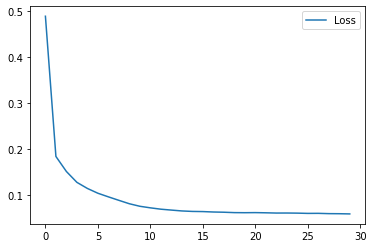

In [177]:
# plot history
plt.plot(history.history['loss'], label = 'Loss')
plt.legend()
plt.show()

#### Make Prediction

In [178]:
# make a prediction
y_test_pre = model.predict(x_test)
# check length
y_test_pre.shape, y_test.shape

36/36 [==============================] - 0s 848us/step


((1140, 1), (1140,))

In [179]:
x_test.shape

(1140, 1, 21)

#### Model Evaluation

In [180]:
y_test_pre

array([[1.1813917 ],
       [1.1472849 ],
       [1.203234  ],
       ...,
       [1.2805526 ],
       [0.8719845 ],
       [0.74854076]], dtype=float32)

In [181]:
y_test_pre.shape

(1140, 1)

In [182]:
def RMSE(actual, prediction):
    rmse = np.sqrt(mean_squared_error(actual, prediction))
    return rmse

In [183]:
print(RMSE(y_test, y_test_pre))

0.13868901443353132


In [184]:
r2_score(y_test, y_test_pre)

0.8256707960907981

## SW

In [185]:
sw = df_region[df_region['region'] == 'sw'].reset_index().drop(columns = ['index', 'region'])
sw.head()

tract  year  mean_rent_per  property_sqft  current_rent  \
0  35013000102  2016       0.639167        76400.0         713.0   
1  35013000102  2017       0.681667        76400.0         713.0   
2  35013000102  2018       0.651667        76400.0         713.0   
3  35013000102  2019       0.681667        76400.0         713.0   
4  35013000102  2020       0.675000        76400.0         713.0   

   property_value  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
0   116362.833333           0.0408              0.0535               0.05125   
1   119829.083333           0.0408              0.0535               0.05125   
2   125330.333333           0.0408              0.0535               0.05125   
3   138069.833333           0.0408              0.0535               0.05125   
4   135117.750000           0.0408              0.0535               0.05125   

   avg_local_sales_tax_rate  ...  mean_rent_scaled  starbucks_vists_per  \
0                  0.027137  ...      48631.916667             0.264085   
1                  0.027137  ...      52199.583333             0.264085   
2                  0.027137  ...      49677.833333             0.264085   
3                  0.027137  ...      51994.250000             0.264085   
4                  0.027137  ...      51557.916667             0.264085   

   grocery_vists_per  hospitals_per  colleges_per  banks_per  \
0           0.088028            0.0      0.176056   0.528169   
1           0.088028            0.0      0.176056   0.528169   
2           0.088028            0.0      0.176056   0.528169   
3           0.088028            0.0      0.176056   0.528169   
4           0.088028            0.0      0.176056   0.528169   

   public_schools_per  private_schools_per  employment_rate  target_value  
0            1.584507             0.176056         0.865867      0.639167  
1            1.584507             0.176056         0.909542      0.681667  
2            1.584507             0.176056         0.909183      0.651667  
3            1.584507             0.176056         0.936387      0.681667  
4            1.584507             0.176056         0.950870      0.675000  

[5 rows x 63 columns]

### Data Standardization

In [186]:
# normalized data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(sw.drop(columns = ['tract', 'year', 'target_value']))
# create datefrane for scaled data
scaled_df = pd.DataFrame(data = scaled, columns = sw.drop(columns = ['tract', 'year', 'target_value']).columns)

In [187]:
df1 = sw.copy()

In [188]:
# Put scaled_df to df1
df1[scaled_df.columns] = np.array(scaled_df)
df1['tract_new'] = list(df1.tract)
df1.shape

(19880, 64)

In [189]:
# Set tract and year as index
df1 = df1.set_index(['tract','year'])
df1.head()

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
35013000102 2016       0.050720       0.039027      0.088121        0.034814   
            2017       0.065171       0.039027      0.088121        0.036437   
            2018       0.054970       0.039027      0.088121        0.039013   
            2019       0.065171       0.039027      0.088121        0.044978   
            2020       0.062904       0.039027      0.088121        0.043596   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
35013000102 2016              1.0                 1.0              0.357143   
            2017              1.0                 1.0              0.357143   
            2018              1.0                 1.0              0.357143   
            2019              1.0                 1.0              0.357143   
            2020              1.0                 1.0              0.357143   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
35013000102 2016                  0.304115            0.0   
            2017                  0.304115            0.0   
            2018                  0.304115            0.0   
            2019                  0.304115            0.0   
            2020                  0.304115            0.0   

                  max_local_sales_tax  ...  starbucks_vists_per  \
tract       year                       ...                        
35013000102 2016               0.4625  ...             0.046875   
            2017               0.4625  ...             0.046875   
            2018               0.4625  ...             0.046875   
            2019               0.4625  ...             0.046875   
            2020               0.4625  ...             0.046875   

                  grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract       year                                                              
35013000102 2016           0.040493            0.0      0.118545   0.001317   
            2017           0.040493            0.0      0.118545   0.001317   
            2018           0.040493            0.0      0.118545   0.001317   
            2019           0.040493            0.0      0.118545   0.001317   
            2020           0.040493            0.0      0.118545   0.001317   

                  public_schools_per  private_schools_per  employment_rate  \
tract       year                                                             
35013000102 2016            0.238608             0.078303         0.818711   
            2017            0.238608             0.078303         0.877741   
            2018            0.238608             0.078303         0.877255   
            2019            0.238608             0.078303         0.914023   
            2020            0.238608             0.078303         0.933598   

                  target_value    tract_new  
tract       year                             
35013000102 2016      0.639167  35013000102  
            2017      0.681667  35013000102  
            2018      0.651667  35013000102  
            2019      0.681667  35013000102  
            2020      0.675000  35013000102  

[5 rows x 62 columns]

In [190]:
df1['tract_new'].nunique()

2840

### Train-Test Split

In [191]:
# Because this is panel data so I will split each tract's data 
def train_test_split(data):
    # for train data will be collected from each tract's data which index is from 0-size (80%)
    x_train = data.drop(columns = ['target_value']).iloc[0:6] 
    # for test data will be collected from each tract's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['target_value']).iloc[3:]
    y_train = data['target_value'].iloc[0:6] 
    y_test = data['target_value'].iloc[3:] 
    return x_train, x_test, y_train, y_test

In [192]:
# get all unique tracts
tract = list(set(df1.tract_new))
# loop each tract and split the data into train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0, len(tract)):
    data = df1[df1['tract_new'] == tract[i]]
    # applied the function I created above
    x_train, x_test, y_train, y_test = train_test_split(data) 
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [193]:
X_train[0].head(10)

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
48355003205 2016       0.194237       0.151529       0.25454        0.044317   
            2017       0.194237       0.151529       0.25454        0.047182   
            2018       0.203446       0.151529       0.25454        0.047855   
            2019       0.214921       0.151529       0.25454        0.048658   
            2020       0.212229       0.151529       0.25454        0.052191   
            2021       0.254590       0.151529       0.25454        0.061197   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
48355003205 2016              0.0                 0.0                   1.0   
            2017              0.0                 0.0                   1.0   
            2018              0.0                 0.0                   1.0   
            2019              0.0                 0.0                   1.0   
            2020              0.0                 0.0                   1.0   
            2021              0.0                 0.0                   1.0   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
48355003205 2016              3.996803e-15       0.317188   
            2017              3.996803e-15       0.317188   
            2018              3.996803e-15       0.317188   
            2019              3.996803e-15       0.317188   
            2020              3.996803e-15       0.317188   
            2021              3.996803e-15       0.317188   

                  max_local_sales_tax  ...  mean_rent_scaled  \
tract       year                       ...                     
48355003205 2016         1.998401e-15  ...          0.079181   
            2017         1.998401e-15  ...          0.079094   
            2018         1.998401e-15  ...          0.080992   
            2019         1.998401e-15  ...          0.083484   
            2020         1.998401e-15  ...          0.082912   
            2021         1.998401e-15  ...          0.093211   

                  starbucks_vists_per  grocery_vists_per  hospitals_per  \
tract       year                                                          
48355003205 2016             0.080682           0.104545       0.023864   
            2017             0.080682           0.104545       0.023864   
            2018             0.080682           0.104545       0.023864   
            2019             0.080682           0.104545       0.023864   
            2020             0.080682           0.104545       0.023864   
            2021             0.080682           0.104545       0.023864   

                  colleges_per  banks_per  public_schools_per  \
tract       year                                                
48355003205 2016      0.076515        0.0            0.119786   
            2017      0.076515        0.0            0.119786   
            2018      0.076515        0.0            0.119786   
            2019      0.076515        0.0            0.119786   
            2020      0.076515        0.0            0.119786   
            2021      0.076515        0.0            0.119786   

                  private_schools_per  employment_rate    tract_new  
tract       year                                                     
48355003205 2016             0.101082         0.898174  48355003205  
            2017             0.101082         0.926496  48355003205  
            2018             0.101082         0.923882  48355003205  
            2019             0.101082         0.916075  48355003205  
            2020             0.101082         0.931111  48355003205  
            2021             0.101082         0.929349  48355003205  

[6 rows x 61 columns]

In [194]:
Y_test[0].head(10)

tract        year
48355003205  2019    1.122083
             2020    1.114167
             2021    1.238750
             2022    1.255000
Name: target_value, dtype: float64

In [195]:
# concatenate each train dataset in X_train list and Y_train list respectively 
X_train = pd.concat(X_train)
Y_train = pd.DataFrame(pd.concat(Y_train))
# concatenate each test dataset in X_test list and Y_test list respectively
X_test = pd.concat(X_test)
Y_test = pd.DataFrame(pd.concat(Y_test))

In [196]:
# double check the train data and test data and our target 
X_train.head()

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
48355003205 2016       0.194237       0.151529       0.25454        0.044317   
            2017       0.194237       0.151529       0.25454        0.047182   
            2018       0.203446       0.151529       0.25454        0.047855   
            2019       0.214921       0.151529       0.25454        0.048658   
            2020       0.212229       0.151529       0.25454        0.052191   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
48355003205 2016              0.0                 0.0                   1.0   
            2017              0.0                 0.0                   1.0   
            2018              0.0                 0.0                   1.0   
            2019              0.0                 0.0                   1.0   
            2020              0.0                 0.0                   1.0   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
48355003205 2016              3.996803e-15       0.317188   
            2017              3.996803e-15       0.317188   
            2018              3.996803e-15       0.317188   
            2019              3.996803e-15       0.317188   
            2020              3.996803e-15       0.317188   

                  max_local_sales_tax  ...  mean_rent_scaled  \
tract       year                       ...                     
48355003205 2016         1.998401e-15  ...          0.079181   
            2017         1.998401e-15  ...          0.079094   
            2018         1.998401e-15  ...          0.080992   
            2019         1.998401e-15  ...          0.083484   
            2020         1.998401e-15  ...          0.082912   

                  starbucks_vists_per  grocery_vists_per  hospitals_per  \
tract       year                                                          
48355003205 2016             0.080682           0.104545       0.023864   
            2017             0.080682           0.104545       0.023864   
            2018             0.080682           0.104545       0.023864   
            2019             0.080682           0.104545       0.023864   
            2020             0.080682           0.104545       0.023864   

                  colleges_per  banks_per  public_schools_per  \
tract       year                                                
48355003205 2016      0.076515        0.0            0.119786   
            2017      0.076515        0.0            0.119786   
            2018      0.076515        0.0            0.119786   
            2019      0.076515        0.0            0.119786   
            2020      0.076515        0.0            0.119786   

                  private_schools_per  employment_rate    tract_new  
tract       year                                                     
48355003205 2016             0.101082         0.898174  48355003205  
            2017             0.101082         0.926496  48355003205  
            2018             0.101082         0.923882  48355003205  
            2019             0.101082         0.916075  48355003205  
            2020             0.101082         0.931111  48355003205  

[5 rows x 61 columns]

In [197]:
X_train.shape

(17040, 61)

In [198]:
X_train['tract_new'].nunique() * 6

17040

### Data Preprocessing

In [199]:
#combine X train and Y train as train data 
train_data = pd.DataFrame()
train_data[X_train.columns] = X_train
train_data[Y_train.columns] = Y_train
#combine X test and Y test as test data 
test_data = pd.DataFrame()
test_data[X_test.columns] = X_test
test_data[Y_test.columns] = Y_test

In [200]:
train_data.head(10)

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
48355003205 2016       0.194237       0.151529      0.254540        0.044317   
            2017       0.194237       0.151529      0.254540        0.047182   
            2018       0.203446       0.151529      0.254540        0.047855   
            2019       0.214921       0.151529      0.254540        0.048658   
            2020       0.212229       0.151529      0.254540        0.052191   
            2021       0.254590       0.151529      0.254540        0.061197   
48201522201 2016       0.118582       0.126352      0.177285        0.140276   
            2017       0.126941       0.126352      0.177285        0.141788   
            2018       0.141533       0.126352      0.177285        0.147078   
            2019       0.157684       0.126352      0.177285        0.151596   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
48355003205 2016              0.0                 0.0                   1.0   
            2017              0.0                 0.0                   1.0   
            2018              0.0                 0.0                   1.0   
            2019              0.0                 0.0                   1.0   
            2020              0.0                 0.0                   1.0   
            2021              0.0                 0.0                   1.0   
48201522201 2016              0.0                 0.0                   1.0   
            2017              0.0                 0.0                   1.0   
            2018              0.0                 0.0                   1.0   
            2019              0.0                 0.0                   1.0   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
48355003205 2016              3.996803e-15       0.317188   
            2017              3.996803e-15       0.317188   
            2018              3.996803e-15       0.317188   
            2019              3.996803e-15       0.317188   
            2020              3.996803e-15       0.317188   
            2021              3.996803e-15       0.317188   
48201522201 2016              3.996803e-15       0.317188   
            2017              3.996803e-15       0.317188   
            2018              3.996803e-15       0.317188   
            2019              3.996803e-15       0.317188   

                  max_local_sales_tax  ...  starbucks_vists_per  \
tract       year                       ...                        
48355003205 2016         1.998401e-15  ...             0.080682   
            2017         1.998401e-15  ...             0.080682   
            2018         1.998401e-15  ...             0.080682   
            2019         1.998401e-15  ...             0.080682   
            2020         1.998401e-15  ...             0.080682   
            2021         1.998401e-15  ...             0.080682   
48201522201 2016         1.998401e-15  ...             0.036126   
            2017         1.998401e-15  ...             0.036126   
            2018         1.998401e-15  ...             0.036126   
            2019         1.998401e-15  ...             0.036126   

                  grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract       year                                                              
48355003205 2016           0.104545       0.023864      0.076515        0.0   
            2017           0.104545       0.023864      0.076515        0.0   
            2018           0.104545       0.023864      0.076515        0.0   
            2019           0.104545       0.023864      0.076515        0.0   
            2020           0.104545       0.023864      0.076515        0.0   
            2021 

In [201]:
test_data.head(10)

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
48355003205 2019       0.214921       0.151529      0.254540        0.048658   
            2020       0.212229       0.151529      0.254540        0.052191   
            2021       0.254590       0.151529      0.254540        0.061197   
            2022       0.260116       0.151529      0.254540        0.068291   
48201522201 2019       0.157684       0.126352      0.177285        0.151596   
            2020       0.156551       0.126352      0.177285        0.153346   
            2021       0.177094       0.126352      0.177285        0.167784   
            2022       0.195512       0.126352      0.177285        0.182025   
40143003100 2019       0.295157       0.090389      0.257517        0.040023   
            2020       0.358195       0.106156      0.296145        0.041206   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
48355003205 2019         0.000000            0.000000          1.000000e+00   
            2020         0.000000            0.000000          1.000000e+00   
            2021         0.000000            0.000000          1.000000e+00   
            2022         0.000000            0.000000          1.000000e+00   
48201522201 2019         0.000000            0.000000          1.000000e+00   
            2020         0.000000            0.000000          1.000000e+00   
            2021         0.000000            0.000000          1.000000e+00   
            2022         0.000000            0.000000          1.000000e+00   
40143003100 2019         0.571895            0.747664          5.773160e-15   
            2020         0.571895            0.747664          5.773160e-15   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
48355003205 2019              3.996803e-15       0.317188   
            2020              3.996803e-15       0.317188   
            2021              3.996803e-15       0.317188   
            2022              3.996803e-15       0.317188   
48201522201 2019              3.996803e-15       0.317188   
            2020              3.996803e-15       0.317188   
            2021              3.996803e-15       0.317188   
            2022              3.996803e-15       0.317188   
40143003100 2019              1.000000e+00       1.000000   
            2020              1.000000e+00       1.000000   

                  max_local_sales_tax  ...  starbucks_vists_per  \
tract       year                       ...                        
48355003205 2019         1.998401e-15  ...             0.080682   
            2020         1.998401e-15  ...             0.080682   
            2021         1.998401e-15  ...             0.080682   
            2022         1.998401e-15  ...             0.080682   
48201522201 2019         1.998401e-15  ...             0.036126   
            2020         1.998401e-15  ...             0.036126   
            2021         1.998401e-15  ...             0.036126   
            2022         1.998401e-15  ...             0.036126   
40143003100 2019         1.000000e+00  ...             0.000000   
            2020         1.000000e+00  ...             0.000000   

                  grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract       year                                                              
48355003205 2019           0.104545       0.023864      0.076515        0.0   
            2020           0.104545       0.023864      0.076515        0.0   
            2021           0.104545       0.023864      0.076515        0.0   
            2022           0.104545       0.023864      0.076515        0.0   
48201522201 2019           0.156038       0.028494      0.091361        0.0   
            2020 

In [202]:
# Code Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning
def series_to_supervised(data, n_in = 0, n_out = -3, dropnan = True):
    df2 = pd.DataFrame(data)
    tract = list(set(df2['tract_new']))
    agg = pd.DataFrame()
    for i in range(0, len(tract)):
        each_tract = df2[df2['tract_new'] == tract[i]]
        cols = []
        agg1 = pd.DataFrame()
    # input sequence (t-n, ... t-1)
        cols.append(each_tract.shift(n_in))
    # forecast sequence (t, t+1, ... t+n)
        cols.append(each_tract.shift(n_out))
        agg1 = pd.concat(cols, axis = 1)
        agg = agg.append(agg1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

In [203]:
# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except
    reframed_train = series_to_supervised(train).drop(columns = ['tract_new'])
    reframed_test = series_to_supervised(test).drop(columns = ['tract_new'])
    names = df1.columns.to_list()
    names.remove('tract_new')
    present = []
    future = []
    for i in names:
        present.append(i)
        future.append(f'{i}_t+3')
    names = present + future
    reframed_train.columns = names
    reframed_test.columns = names
    # split into train and test sets
    train = reframed_train.values
    test = reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :21], train[:, -1]
    test_X, y_test = test[:, :21], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test

In [204]:
# using the function to obtian reshaped x_train,x_test,y_train,y_test
x_train, x_test, y_train, y_test = reshape_data(train_data, test_data)

In [205]:
x_test.shape

(2840, 1, 21)

In [206]:
x_train.shape

(8520, 1, 21)

### Model: LSTM

In [207]:
# def create_model():
#     # create model
#     model = Sequential()
#     model.add(LSTM(60, activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[2])))
#     model.add(Dense(1))
#     model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])
#     return model

In [208]:
# # Create the model
# model = KerasRegressor(build_fn = create_model, verbose = 0)
# # Define the grid search parameters
# batch_size = [10,20,40]
# epochs = [10,50,100]
# # Make a dictionary of the grid search parameters
# param_grid = dict(batch_size = batch_size, epochs = epochs)
# # Build and fit the GridSearchCV
# grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(), verbose = 10)
# grid_result = grid.fit(x_train, y_train)

In [209]:
# print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#   print('{},{} with: {}'.format(mean, stdev, param))

In [210]:
model = Sequential()
model.add(LSTM(60, activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])

In [211]:
# fit network
history = model.fit(x_train, y_train, epochs = 30, batch_size = 50,  verbose = 1, shuffle = False)

Epoch 1/30
171/171 [==============================] - 1s 893us/step - loss: 0.4285 - accuracy: 5.8685e-04
Epoch 2/30
171/171 [==============================] - 0s 899us/step - loss: 0.1344 - accuracy: 8.2160e-04
Epoch 3/30
171/171 [==============================] - 0s 895us/step - loss: 0.0997 - accuracy: 8.2160e-04
Epoch 4/30
171/171 [==============================] - 0s 894us/step - loss: 0.0806 - accuracy: 8.2160e-04
Epoch 5/30
171/171 [==============================] - 0s 912us/step - loss: 0.0752 - accuracy: 8.2160e-04
Epoch 6/30
171/171 [==============================] - 0s 825us/step - loss: 0.0724 - accuracy: 8.2160e-04
Epoch 7/30
171/171 [==============================] - 0s 818us/step - loss: 0.0708 - accuracy: 8.2160e-04
Epoch 8/30
171/171 [==============================] - 0s 821us/step - loss: 0.0696 - accuracy: 8.2160e-04
Epoch 9/30
171/171 [==============================] - 0s 911us/step - loss: 0.0685 - accuracy: 8.2160e-04
Epoch 10/30
171/171 [=========================

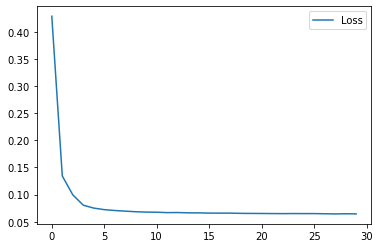

In [212]:
# plot history
plt.plot(history.history['loss'], label = 'Loss')
plt.legend()
plt.show()

#### Make Prediction

In [213]:
# make a prediction
y_test_pre = model.predict(x_test)
# check length
y_test_pre.shape, y_test.shape

89/89 [==============================] - 0s 664us/step


((2840, 1), (2840,))

In [214]:
x_test.shape

(2840, 1, 21)

#### Model Evaluation

In [215]:
y_test_pre

array([[1.1715907],
       [1.0592119],
       [1.4174343],
       ...,
       [0.971432 ],
       [2.3390682],
       [0.8864614]], dtype=float32)

In [216]:
y_test_pre.shape

(2840, 1)

In [217]:
def RMSE(actual, prediction):
    rmse = np.sqrt(mean_squared_error(actual, prediction))
    return rmse

In [218]:
print(RMSE(y_test, y_test_pre))

0.19232189959127002


In [219]:
r2_score(y_test, y_test_pre)

0.7093991028266037

## W

In [220]:
w = df_region[df_region['region'] == 'w'].reset_index().drop(columns = ['index', 'region'])
w.head()

tract  year  mean_rent_per  property_sqft  current_rent  \
0  4013030401  2016       1.198333        44836.0        1108.0   
1  4013030401  2017       1.280000        44836.0        1108.0   
2  4013030401  2018       1.374167        44836.0        1108.0   
3  4013030401  2019       1.419167        44836.0        1108.0   
4  4013030401  2020       1.470000        44836.0        1108.0   

   property_value  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
0   707153.833333           0.0365               0.049                 0.056   
1   708331.166667           0.0365               0.049                 0.056   
2   722860.333333           0.0365               0.049                 0.056   
3   739992.666667           0.0365               0.049                 0.056   
4   802907.083333           0.0365               0.049                 0.056   

   avg_local_sales_tax_rate  ...  mean_rent_scaled  starbucks_vists_per  \
0                  0.027962  ...           53564.5                  0.0   
1                  0.027962  ...           57348.5                  0.0   
2                  0.027962  ...           61578.0                  0.0   
3                  0.027962  ...           63640.5                  0.0   
4                  0.027962  ...           65923.0                  0.0   

   grocery_vists_per  hospitals_per  colleges_per  banks_per  \
0                0.0            0.0           0.0        0.0   
1                0.0            0.0           0.0        0.0   
2                0.0            0.0           0.0        0.0   
3                0.0            0.0           0.0        0.0   
4                0.0            0.0           0.0        0.0   

   public_schools_per  private_schools_per  employment_rate  target_value  
0                 0.0                  0.0         0.977397      1.198333  
1                 0.0                  0.0         0.977843      1.280000  
2                 0.0                  0.0         1.000000      1.374167  
3                 0.0                  0.0         0.998796      1.419167  
4                 0.0                  0.0         0.998967      1.470000  

[5 rows x 63 columns]

### Data Standardization

In [221]:
# normalized data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(w.drop(columns = ['tract', 'year', 'target_value']))
# create datefrane for scaled data
scaled_df = pd.DataFrame(data = scaled, columns = w.drop(columns = ['tract', 'year', 'target_value']).columns)

In [222]:
df1 = w.copy()

In [223]:
# Put scaled_df to df1
df1[scaled_df.columns] = np.array(scaled_df)
df1['tract_new'] = list(df1.tract)
df1.shape

(12250, 64)

In [224]:
# Set tract and year as index
df1 = df1.set_index(['tract','year'])
df1.head()

mean_rent_per  property_sqft  current_rent  property_value  \
tract      year                                                               
4013030401 2016       0.190274       0.034548      0.170086        0.240143   
           2017       0.218441       0.034548      0.170086        0.240606   
           2018       0.250920       0.034548      0.170086        0.246322   
           2019       0.266441       0.034548      0.170086        0.253063   
           2020       0.283973       0.034548      0.170086        0.277816   

                 income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract      year                                                              
4013030401 2016         0.737374            0.753846              0.683544   
           2017         0.737374            0.753846              0.683544   
           2018         0.737374            0.753846              0.683544   
           2019         0.737374            0.753846              0.683544   
           2020         0.737374            0.753846              0.683544   

                 avg_local_sales_tax_rate  combined_rate  max_local_sales_tax  \
tract      year                                                                 
4013030401 2016                   0.57236            1.0             0.601476   
           2017                   0.57236            1.0             0.601476   
           2018                   0.57236            1.0             0.601476   
           2019                   0.57236            1.0             0.601476   
           2020                   0.57236            1.0             0.601476   

                 ...  starbucks_vists_per  grocery_vists_per  hospitals_per  \
tract      year  ...                                                          
4013030401 2016  ...                  0.0                0.0            0.0   
           2017  ...                  0.0                0.0            0.0   
           2018  ...                  0.0                0.0            0.0   
           2019  ...                  0.0                0.0            0.0   
           2020  ...                  0.0                0.0            0.0   

                 colleges_per  banks_per  public_schools_per  \
tract      year                                                
4013030401 2016           0.0        0.0                 0.0   
           2017           0.0        0.0                 0.0   
           2018           0.0        0.0                 0.0   
           2019           0.0        0.0                 0.0   
           2020           0.0        0.0                 0.0   

                 private_schools_per  employment_rate  target_value  \
tract      year                                                       
4013030401 2016                  0.0         0.953153      1.198333   
           2017                  0.0         0.954077      1.280000   
           2018                  0.0         1.000000      1.374167   
           2019                  0.0         0.997504      1.419167   
           2020                  0.0         0.997860      1.470000   

                  tract_new  
tract      year              
4013030401 2016  4013030401  
           2017  4013030401  
           2018  4013030401  
           2019  4013030401  
           2020  4013030401  

[5 rows x 62 columns]

In [225]:
df1['tract_new'].nunique()

1750

### Train-Test Split

In [226]:
# Because this is panel data so I will split each tract's data 
def train_test_split(data):
    # for train data will be collected from each tract's data which index is from 0-size (80%)
    x_train = data.drop(columns = ['target_value']).iloc[0:6] 
    # for test data will be collected from each tract's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['target_value']).iloc[3:]
    y_train = data['target_value'].iloc[0:6] 
    y_test = data['target_value'].iloc[3:] 
    return x_train, x_test, y_train, y_test

In [227]:
# get all unique tracts
tract = list(set(df1.tract_new))
# loop each tract and split the data into train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0, len(tract)):
    data = df1[df1['tract_new'] == tract[i]]
    # applied the function I created above
    x_train, x_test, y_train, y_test = train_test_split(data) 
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [228]:
X_train[0].head(10)

mean_rent_per  property_sqft  current_rent  property_value  \
tract      year                                                               
4013109001 2016       0.163723       0.074194      0.148974        0.010169   
           2017       0.196848       0.074194      0.148974        0.016731   
           2018       0.214776       0.074194      0.148974        0.021631   
           2019       0.261015       0.074194      0.148974        0.026552   
           2020       0.302476       0.074194      0.148974        0.035452   
           2021       0.359997       0.074194      0.148974        0.057583   

                 income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract      year                                                              
4013109001 2016         0.737374            0.753846              0.683544   
           2017         0.737374            0.753846              0.683544   
           2018         0.737374            0.753846              0.683544   
           2019         0.737374            0.753846              0.683544   
           2020         0.737374            0.753846              0.683544   
           2021         0.737374            0.753846              0.683544   

                 avg_local_sales_tax_rate  combined_rate  max_local_sales_tax  \
tract      year                                                                 
4013109001 2016                   0.57236            1.0             0.601476   
           2017                   0.57236            1.0             0.601476   
           2018                   0.57236            1.0             0.601476   
           2019                   0.57236            1.0             0.601476   
           2020                   0.57236            1.0             0.601476   
           2021                   0.57236            1.0             0.601476   

                 ...  mean_rent_scaled  starbucks_vists_per  \
tract      year  ...                                          
4013109001 2016  ...          0.027609             0.017324   
           2017  ...          0.030832             0.017324   
           2018  ...          0.033048             0.017324   
           2019  ...          0.037457             0.017324   
           2020  ...          0.041452             0.017324   
           2021  ...          0.047344             0.017324   

                 grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract      year                                                              
4013109001 2016                0.0       0.075457      0.143728        0.0   
           2017                0.0       0.075457      0.143728        0.0   
           2018                0.0       0.075457      0.143728        0.0   
           2019                0.0       0.075457      0.143728        0.0   
           2020                0.0       0.075457      0.143728        0.0   
           2021                0.0       0.075457      0.143728        0.0   

                 public_schools_per  private_schools_per  employment_rate  \
tract      year                                                             
4013109001 2016            0.545146              0.23424         0.796383   
           2017            0.545146              0.23424         0.877967   
           2018            0.545146              0.23424         0.872272   
           2019            0.545146              0.23424         0.847804   
           2020            0.545146              0.23424         0.882897   
           2021            0.545146              0.23424         0.864687   

                  tract_new  
tract      year              
4013109001 2016  4013109001  
           2017  4013109001  
           2018  4013109001  
           2019  4013109001  
           2020  4013109001  
           2021  4013109001  

[6 rows x 61 columns]

In [229]:
Y_test[0].head(10)

tract       year
4013109001  2019    1.403437
            2020    1.523646
            2021    1.690417
            2022    1.947250
Name: target_value, dtype: float64

In [230]:
# concatenate each train dataset in X_train list and Y_train list respectively 
X_train = pd.concat(X_train)
Y_train = pd.DataFrame(pd.concat(Y_train))
# concatenate each test dataset in X_test list and Y_test list respectively
X_test = pd.concat(X_test)
Y_test = pd.DataFrame(pd.concat(Y_test))

In [231]:
# double check the train data and test data and our target 
X_train.head()

mean_rent_per  property_sqft  current_rent  property_value  \
tract      year                                                               
4013109001 2016       0.163723       0.074194      0.148974        0.010169   
           2017       0.196848       0.074194      0.148974        0.016731   
           2018       0.214776       0.074194      0.148974        0.021631   
           2019       0.261015       0.074194      0.148974        0.026552   
           2020       0.302476       0.074194      0.148974        0.035452   

                 income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract      year                                                              
4013109001 2016         0.737374            0.753846              0.683544   
           2017         0.737374            0.753846              0.683544   
           2018         0.737374            0.753846              0.683544   
           2019         0.737374            0.753846              0.683544   
           2020         0.737374            0.753846              0.683544   

                 avg_local_sales_tax_rate  combined_rate  max_local_sales_tax  \
tract      year                                                                 
4013109001 2016                   0.57236            1.0             0.601476   
           2017                   0.57236            1.0             0.601476   
           2018                   0.57236            1.0             0.601476   
           2019                   0.57236            1.0             0.601476   
           2020                   0.57236            1.0             0.601476   

                 ...  mean_rent_scaled  starbucks_vists_per  \
tract      year  ...                                          
4013109001 2016  ...          0.027609             0.017324   
           2017  ...          0.030832             0.017324   
           2018  ...          0.033048             0.017324   
           2019  ...          0.037457             0.017324   
           2020  ...          0.041452             0.017324   

                 grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract      year                                                              
4013109001 2016                0.0       0.075457      0.143728        0.0   
           2017                0.0       0.075457      0.143728        0.0   
           2018                0.0       0.075457      0.143728        0.0   
           2019                0.0       0.075457      0.143728        0.0   
           2020                0.0       0.075457      0.143728        0.0   

                 public_schools_per  private_schools_per  employment_rate  \
tract      year                                                             
4013109001 2016            0.545146              0.23424         0.796383   
           2017            0.545146              0.23424         0.877967   
           2018            0.545146              0.23424         0.872272   
           2019            0.545146              0.23424         0.847804   
           2020            0.545146              0.23424         0.882897   

                  tract_new  
tract      year              
4013109001 2016  4013109001  
           2017  4013109001  
           2018  4013109001  
           2019  4013109001  
           2020  4013109001  

[5 rows x 61 columns]

In [232]:
X_train.shape

(10500, 61)

In [233]:
X_train['tract_new'].nunique() * 6

10500

### Data Preprocessing

In [234]:
#combine X train and Y train as train data 
train_data = pd.DataFrame()
train_data[X_train.columns] = X_train
train_data[Y_train.columns] = Y_train
#combine X test and Y test as test data 
test_data = pd.DataFrame()
test_data[X_test.columns] = X_test
test_data[Y_test.columns] = Y_test

In [235]:
train_data.head(10)

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
4013109001  2016       0.163723       0.074194      0.148974        0.010169   
            2017       0.196848       0.074194      0.148974        0.016731   
            2018       0.214776       0.074194      0.148974        0.021631   
            2019       0.261015       0.074194      0.148974        0.026552   
            2020       0.302476       0.074194      0.148974        0.035452   
            2021       0.359997       0.074194      0.148974        0.057583   
16001002231 2016       0.159807       0.149644      0.316384        0.048860   
            2017       0.179926       0.149644      0.316384        0.055897   
            2018       0.209818       0.149644      0.316384        0.068272   
            2019       0.201914       0.103540      0.288136        0.081547   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
4013109001  2016         0.737374            0.753846              0.683544   
            2017         0.737374            0.753846              0.683544   
            2018         0.737374            0.753846              0.683544   
            2019         0.737374            0.753846              0.683544   
            2020         0.737374            0.753846              0.683544   
            2021         0.737374            0.753846              0.683544   
16001002231 2016         0.732323            1.000000              0.784810   
            2017         0.732323            1.000000              0.784810   
            2018         0.732323            1.000000              0.784810   
            2019         0.732323            1.000000              0.784810   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
4013109001  2016                   0.57236   1.000000e+00   
            2017                   0.57236   1.000000e+00   
            2018                   0.57236   1.000000e+00   
            2019                   0.57236   1.000000e+00   
            2020                   0.57236   1.000000e+00   
            2021                   0.57236   1.000000e+00   
16001002231 2016                   0.00000   3.996803e-15   
            2017                   0.00000   3.996803e-15   
            2018                   0.00000   3.996803e-15   
            2019                   0.00000   3.996803e-15   

                  max_local_sales_tax  ...  starbucks_vists_per  \
tract       year                       ...                        
4013109001  2016             0.601476  ...             0.017324   
            2017             0.601476  ...             0.017324   
            2018             0.601476  ...             0.017324   
            2019             0.601476  ...             0.017324   
            2020             0.601476  ...             0.017324   
            2021             0.601476  ...             0.017324   
16001002231 2016             0.217712  ...             0.002588   
            2017             0.217712  ...             0.002588   
            2018             0.217712  ...             0.002588   
            2019             0.217712  ...             0.002588   

                  grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract       year                                                              
4013109001  2016           0.000000       0.075457      0.143728        0.0   
            2017           0.000000       0.075457      0.143728        0.0   
            2018           0.000000       0.075457      0.143728        0.0   
            2019           0.000000       0.075457      0.143728        0.0   
            2020           0.000000       0.075457      0.143728        0.0   
            2021 

In [236]:
test_data.head(10)

mean_rent_per  property_sqft  current_rent  property_value  \
tract       year                                                               
4013109001  2019       0.261015       0.074194      0.148974        0.026552   
            2020       0.302476       0.074194      0.148974        0.035452   
            2021       0.359997       0.074194      0.148974        0.057583   
            2022       0.448580       0.074194      0.148974        0.069947   
16001002231 2019       0.201914       0.103540      0.288136        0.081547   
            2020       0.234393       0.103540      0.288136        0.096970   
            2021       0.310560       0.103540      0.288136        0.146318   
            2022       0.347091       0.103540      0.288136        0.164233   
49035100308 2019       0.198321       0.094232      0.212310        0.079705   
            2020       0.224621       0.094232      0.212310        0.091514   

                  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract       year                                                              
4013109001  2019         0.737374            0.753846              0.683544   
            2020         0.737374            0.753846              0.683544   
            2021         0.737374            0.753846              0.683544   
            2022         0.737374            0.753846              0.683544   
16001002231 2019         0.732323            1.000000              0.784810   
            2020         0.732323            1.000000              0.784810   
            2021         0.732323            1.000000              0.784810   
            2022         0.732323            1.000000              0.784810   
49035100308 2019         1.000000            0.761538              0.810127   
            2020         1.000000            0.761538              0.810127   

                  avg_local_sales_tax_rate  combined_rate  \
tract       year                                            
4013109001  2019                  0.572360   1.000000e+00   
            2020                  0.572360   1.000000e+00   
            2021                  0.572360   1.000000e+00   
            2022                  0.572360   1.000000e+00   
16001002231 2019                  0.000000   3.996803e-15   
            2020                  0.000000   3.996803e-15   
            2021                  0.000000   3.996803e-15   
            2022                  0.000000   3.996803e-15   
49035100308 2019                  0.219698   4.905626e-01   
            2020                  0.219698   4.905626e-01   

                  max_local_sales_tax  ...  starbucks_vists_per  \
tract       year                       ...                        
4013109001  2019             0.601476  ...             0.017324   
            2020             0.601476  ...             0.017324   
            2021             0.601476  ...             0.017324   
            2022             0.601476  ...             0.017324   
16001002231 2019             0.217712  ...             0.002588   
            2020             0.217712  ...             0.002588   
            2021             0.217712  ...             0.002588   
            2022             0.217712  ...             0.002588   
49035100308 2019             0.210332  ...             0.007190   
            2020             0.210332  ...             0.007190   

                  grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract       year                                                              
4013109001  2019           0.000000       0.075457      0.143728        0.0   
            2020           0.000000       0.075457      0.143728        0.0   
            2021           0.000000       0.075457      0.143728        0.0   
            2022           0.000000       0.075457      0.143728        0.0   
16001002231 2019           0.013709       0.011274      0.042949        0.0   
            2020 

In [237]:
# Code Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning
def series_to_supervised(data, n_in = 0, n_out = -3, dropnan = True):
    df2 = pd.DataFrame(data)
    tract = list(set(df2['tract_new']))
    agg = pd.DataFrame()
    for i in range(0, len(tract)):
        each_tract = df2[df2['tract_new'] == tract[i]]
        cols = []
        agg1 = pd.DataFrame()
    # input sequence (t-n, ... t-1)
        cols.append(each_tract.shift(n_in))
    # forecast sequence (t, t+1, ... t+n)
        cols.append(each_tract.shift(n_out))
        agg1 = pd.concat(cols, axis = 1)
        agg = agg.append(agg1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

In [238]:
# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except
    reframed_train = series_to_supervised(train).drop(columns = ['tract_new'])
    reframed_test = series_to_supervised(test).drop(columns = ['tract_new'])
    names = df1.columns.to_list()
    names.remove('tract_new')
    present = []
    future = []
    for i in names:
        present.append(i)
        future.append(f'{i}_t+3')
    names = present + future
    reframed_train.columns = names
    reframed_test.columns = names
    # split into train and test sets
    train = reframed_train.values
    test = reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :21], train[:, -1]
    test_X, y_test = test[:, :21], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test

In [239]:
# using the function to obtian reshaped x_train,x_test,y_train,y_test
x_train, x_test, y_train, y_test = reshape_data(train_data, test_data)

In [240]:
x_test.shape

(1750, 1, 21)

In [241]:
x_train.shape

(5250, 1, 21)

### Model: LSTM

In [242]:
# def create_model():
#     # create model
#     model = Sequential()
#     model.add(LSTM(60, activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[2])))
#     model.add(Dense(1))
#     model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])
#     return model

In [243]:
# # Create the model
# model = KerasRegressor(build_fn = create_model, verbose = 0)
# # Define the grid search parameters
# batch_size = [10,20,40]
# epochs = [10,50,100]
# # Make a dictionary of the grid search parameters
# param_grid = dict(batch_size = batch_size, epochs = epochs)
# # Build and fit the GridSearchCV
# grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(), verbose = 10)
# grid_result = grid.fit(x_train, y_train)

In [244]:
# print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#   print('{},{} with: {}'.format(mean, stdev, param))

In [245]:
model = Sequential()
model.add(LSTM(60, activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])

In [246]:
# fit network
history = model.fit(x_train, y_train, epochs = 30, batch_size = 50,  verbose = 1, shuffle = False)

Epoch 1/30
105/105 [==============================] - 1s 2ms/step - loss: 0.5861 - accuracy: 7.6190e-04
Epoch 2/30
105/105 [==============================] - 0s 834us/step - loss: 0.2158 - accuracy: 7.6190e-04
Epoch 3/30
105/105 [==============================] - 0s 829us/step - loss: 0.1741 - accuracy: 7.6190e-04
Epoch 4/30
105/105 [==============================] - 0s 821us/step - loss: 0.1476 - accuracy: 7.6190e-04
Epoch 5/30
105/105 [==============================] - 0s 837us/step - loss: 0.1297 - accuracy: 7.6190e-04
Epoch 6/30
105/105 [==============================] - 0s 838us/step - loss: 0.1153 - accuracy: 7.6190e-04
Epoch 7/30
105/105 [==============================] - 0s 812us/step - loss: 0.1069 - accuracy: 7.6190e-04
Epoch 8/30
105/105 [==============================] - 0s 830us/step - loss: 0.1019 - accuracy: 7.6190e-04
Epoch 9/30
105/105 [==============================] - 0s 835us/step - loss: 0.0987 - accuracy: 7.6190e-04
Epoch 10/30
105/105 [===========================

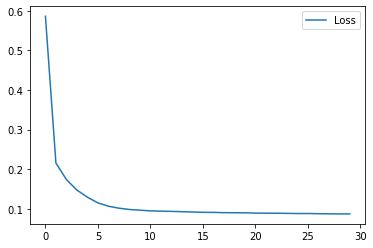

In [247]:
# plot history
plt.plot(history.history['loss'], label = 'Loss')
plt.legend()
plt.show()

#### Make Prediction

In [248]:
# make a prediction
y_test_pre = model.predict(x_test)
# check length
y_test_pre.shape, y_test.shape

55/55 [==============================] - 0s 661us/step


((1750, 1), (1750,))

In [249]:
x_test.shape

(1750, 1, 21)

#### Model Evaluation

In [250]:
y_test_pre

array([[1.7245996],
       [1.5161738],
       [1.4002573],
       ...,
       [1.8851546],
       [1.9462967],
       [1.5349004]], dtype=float32)

In [251]:
y_test_pre.shape

(1750, 1)

In [252]:
def RMSE(actual, prediction):
    rmse = np.sqrt(mean_squared_error(actual, prediction))
    return rmse

In [253]:
print(RMSE(y_test, y_test_pre))

0.2359714575092222


In [254]:
r2_score(y_test, y_test_pre)

0.5692457822445385

## SC

In [255]:
sc = df_region[df_region['region'] == 'sc'].reset_index().drop(columns = ['index', 'region'])
sc.head()

tract  year  mean_rent_per  property_sqft  current_rent  \
0  6037102103  2016       1.879167        29700.0        1787.0   
1  6037102103  2017       2.400833        29700.0        1787.0   
2  6037102103  2018       2.462500        29700.0        1787.0   
3  6037102103  2019       2.262708        47332.0        2021.0   
4  6037102103  2020       2.385833        47332.0        2021.0   

   property_value  income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
0   464251.083333           0.0775              0.0884                0.0725   
1   502148.166667           0.0775              0.0884                0.0725   
2   551296.000000           0.0775              0.0884                0.0725   
3   567823.416667           0.0775              0.0884                0.0725   
4   619998.833333           0.0775              0.0884                0.0725   

   avg_local_sales_tax_rate  ...  mean_rent_scaled  starbucks_vists_per  \
0                  0.015691  ...        55777.5000                  0.0   
1                  0.015691  ...        71383.5000                  0.0   
2                  0.015691  ...        73156.5000                  0.0   
3                  0.015691  ...       103430.0625                  0.0   
4                  0.015691  ...       106946.2500                  0.0   

   grocery_vists_per  hospitals_per  colleges_per  banks_per  \
0                0.0        0.08569           0.0    0.17138   
1                0.0        0.08569           0.0    0.17138   
2                0.0        0.08569           0.0    0.17138   
3                0.0        0.08569           0.0    0.17138   
4                0.0        0.08569           0.0    0.17138   

   public_schools_per  private_schools_per  employment_rate  target_value  
0            1.371037              0.17138         0.858515      1.879167  
1            1.371037              0.17138         0.903318      2.400833  
2            1.371037              0.17138         0.907880      2.462500  
3            1.371037              0.17138         0.913700      2.262708  
4            1.371037              0.17138         0.920479      2.385833  

[5 rows x 63 columns]

### Data Standardization

In [256]:
# normalized data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(sc.drop(columns = ['tract', 'year', 'target_value']))
# create datefrane for scaled data
scaled_df = pd.DataFrame(data = scaled, columns = sc.drop(columns = ['tract', 'year', 'target_value']).columns)

In [257]:
df1 = sc.copy()

In [258]:
# Put scaled_df to df1
df1[scaled_df.columns] = np.array(scaled_df)
df1['tract_new'] = list(df1.tract)
df1.shape

(13958, 64)

In [259]:
# Set tract and year as index
df1 = df1.set_index(['tract','year'])
df1.head()

mean_rent_per  property_sqft  current_rent  property_value  \
tract      year                                                               
6037102103 2016       0.159762       0.006500      0.142506        0.075918   
           2017       0.232977       0.006500      0.142506        0.084068   
           2018       0.241632       0.006500      0.142506        0.094637   
           2019       0.213591       0.013238      0.176360        0.098191   
           2020       0.230872       0.013238      0.176360        0.109412   

                 income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract      year                                                              
6037102103 2016              1.0                 1.0                   0.0   
           2017              1.0                 1.0                   0.0   
           2018              1.0                 1.0                   0.0   
           2019              1.0                 1.0                   0.0   
           2020              1.0                 1.0                   0.0   

                 avg_local_sales_tax_rate  combined_rate  max_local_sales_tax  \
tract      year                                                                 
6037102103 2016                       1.0            1.0                  1.0   
           2017                       1.0            1.0                  1.0   
           2018                       1.0            1.0                  1.0   
           2019                       1.0            1.0                  1.0   
           2020                       1.0            1.0                  1.0   

                 ...  starbucks_vists_per  grocery_vists_per  hospitals_per  \
tract      year  ...                                                          
6037102103 2016  ...                  0.0                0.0       0.033762   
           2017  ...                  0.0                0.0       0.033762   
           2018  ...                  0.0                0.0       0.033762   
           2019  ...                  0.0                0.0       0.033762   
           2020  ...                  0.0                0.0       0.033762   

                 colleges_per  banks_per  public_schools_per  \
tract      year                                                
6037102103 2016           0.0   0.000631             0.07149   
           2017           0.0   0.000631             0.07149   
           2018           0.0   0.000631             0.07149   
           2019           0.0   0.000631             0.07149   
           2020           0.0   0.000631             0.07149   

                 private_schools_per  employment_rate  target_value  \
tract      year                                                       
6037102103 2016             0.035304         0.786659      1.879167   
           2017             0.035304         0.854215      2.400833   
           2018             0.035304         0.861095      2.462500   
           2019             0.035304         0.869871      2.262708   
           2020             0.035304         0.880093      2.385833   

                  tract_new  
tract      year              
6037102103 2016  6037102103  
           2017  6037102103  
           2018  6037102103  
           2019  6037102103  
           2020  6037102103  

[5 rows x 62 columns]

In [260]:
df1['tract_new'].nunique()

1994

### Train-Test Split

In [261]:
# Because this is panel data so I will split each tract's data 
def train_test_split(data):
    # for train data will be collected from each tract's data which index is from 0-size (80%)
    x_train = data.drop(columns = ['target_value']).iloc[0:6] 
    # for test data will be collected from each tract's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['target_value']).iloc[3:]
    y_train = data['target_value'].iloc[0:6] 
    y_test = data['target_value'].iloc[3:] 
    return x_train, x_test, y_train, y_test

In [262]:
# get all unique tracts
tract = list(set(df1.tract_new))
# loop each tract and split the data into train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0, len(tract)):
    data = df1[df1['tract_new'] == tract[i]]
    # applied the function I created above
    x_train, x_test, y_train, y_test = train_test_split(data) 
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [263]:
X_train[0].head(10)

mean_rent_per  property_sqft  current_rent  property_value  \
tract      year                                                               
6065042207 2016       0.102980       0.032197      0.237052        0.046060   
           2017       0.111284       0.032197      0.237052        0.050788   
           2018       0.124675       0.032197      0.237052        0.057343   
           2019       0.131576       0.032197      0.237052        0.060637   
           2020       0.136137       0.032197      0.237052        0.065189   
           2021       0.160172       0.032197      0.237052        0.083657   

                 income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract      year                                                              
6065042207 2016              1.0                 1.0                   0.0   
           2017              1.0                 1.0                   0.0   
           2018              1.0                 1.0                   0.0   
           2019              1.0                 1.0                   0.0   
           2020              1.0                 1.0                   0.0   
           2021              1.0                 1.0                   0.0   

                 avg_local_sales_tax_rate  combined_rate  max_local_sales_tax  \
tract      year                                                                 
6065042207 2016                       1.0            1.0                  1.0   
           2017                       1.0            1.0                  1.0   
           2018                       1.0            1.0                  1.0   
           2019                       1.0            1.0                  1.0   
           2020                       1.0            1.0                  1.0   
           2021                       1.0            1.0                  1.0   

                 ...  mean_rent_scaled  starbucks_vists_per  \
tract      year  ...                                          
6065042207 2016  ...          0.012534             0.022575   
           2017  ...          0.013207             0.022575   
           2018  ...          0.014302             0.022575   
           2019  ...          0.014825             0.022575   
           2020  ...          0.015174             0.022575   
           2021  ...          0.017073             0.022575   

                 grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract      year                                                              
6065042207 2016                0.0            0.0      0.011381        0.0   
           2017                0.0            0.0      0.011381        0.0   
           2018                0.0            0.0      0.011381        0.0   
           2019                0.0            0.0      0.011381        0.0   
           2020                0.0            0.0      0.011381        0.0   
           2021                0.0            0.0      0.011381        0.0   

                 public_schools_per  private_schools_per  employment_rate  \
tract      year                                                             
6065042207 2016             0.02322                  0.0         0.884973   
           2017             0.02322                  0.0         0.859335   
           2018             0.02322                  0.0         0.938404   
           2019             0.02322                  0.0         0.929822   
           2020             0.02322                  0.0         0.939169   
           2021             0.02322                  0.0         0.929445   

                  tract_new  
tract      year              
6065042207 2016  6065042207  
           2017  6065042207  
           2018  6065042207  
           2019  6065042207  
           2020  6065042207  
           2021  6065042207  

[6 rows x 61 columns]

In [264]:
Y_test[0].head(10)

tract       year
6065042207  2019    1.678333
            2020    1.710833
            2021    1.882083
            2022    2.197000
Name: target_value, dtype: float64

In [265]:
# concatenate each train dataset in X_train list and Y_train list respectively 
X_train = pd.concat(X_train)
Y_train = pd.DataFrame(pd.concat(Y_train))
# concatenate each test dataset in X_test list and Y_test list respectively
X_test = pd.concat(X_test)
Y_test = pd.DataFrame(pd.concat(Y_test))

In [266]:
# double check the train data and test data and our target 
X_train.head()

mean_rent_per  property_sqft  current_rent  property_value  \
tract      year                                                               
6065042207 2016       0.102980       0.032197      0.237052        0.046060   
           2017       0.111284       0.032197      0.237052        0.050788   
           2018       0.124675       0.032197      0.237052        0.057343   
           2019       0.131576       0.032197      0.237052        0.060637   
           2020       0.136137       0.032197      0.237052        0.065189   

                 income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract      year                                                              
6065042207 2016              1.0                 1.0                   0.0   
           2017              1.0                 1.0                   0.0   
           2018              1.0                 1.0                   0.0   
           2019              1.0                 1.0                   0.0   
           2020              1.0                 1.0                   0.0   

                 avg_local_sales_tax_rate  combined_rate  max_local_sales_tax  \
tract      year                                                                 
6065042207 2016                       1.0            1.0                  1.0   
           2017                       1.0            1.0                  1.0   
           2018                       1.0            1.0                  1.0   
           2019                       1.0            1.0                  1.0   
           2020                       1.0            1.0                  1.0   

                 ...  mean_rent_scaled  starbucks_vists_per  \
tract      year  ...                                          
6065042207 2016  ...          0.012534             0.022575   
           2017  ...          0.013207             0.022575   
           2018  ...          0.014302             0.022575   
           2019  ...          0.014825             0.022575   
           2020  ...          0.015174             0.022575   

                 grocery_vists_per  hospitals_per  colleges_per  banks_per  \
tract      year                                                              
6065042207 2016                0.0            0.0      0.011381        0.0   
           2017                0.0            0.0      0.011381        0.0   
           2018                0.0            0.0      0.011381        0.0   
           2019                0.0            0.0      0.011381        0.0   
           2020                0.0            0.0      0.011381        0.0   

                 public_schools_per  private_schools_per  employment_rate  \
tract      year                                                             
6065042207 2016             0.02322                  0.0         0.884973   
           2017             0.02322                  0.0         0.859335   
           2018             0.02322                  0.0         0.938404   
           2019             0.02322                  0.0         0.929822   
           2020             0.02322                  0.0         0.939169   

                  tract_new  
tract      year              
6065042207 2016  6065042207  
           2017  6065042207  
           2018  6065042207  
           2019  6065042207  
           2020  6065042207  

[5 rows x 61 columns]

In [267]:
X_train.shape

(11964, 61)

In [268]:
X_train['tract_new'].nunique() * 6

11964

### Data Preprocessing

In [269]:
#combine X train and Y train as train data 
train_data = pd.DataFrame()
train_data[X_train.columns] = X_train
train_data[Y_train.columns] = Y_train
#combine X test and Y test as test data 
test_data = pd.DataFrame()
test_data[X_test.columns] = X_test
test_data[Y_test.columns] = Y_test

In [270]:
train_data.head(10)

mean_rent_per  property_sqft  current_rent  property_value  \
tract      year                                                               
6065042207 2016       0.102980       0.032197      0.237052        0.046060   
           2017       0.111284       0.032197      0.237052        0.050788   
           2018       0.124675       0.032197      0.237052        0.057343   
           2019       0.131576       0.032197      0.237052        0.060637   
           2020       0.136137       0.032197      0.237052        0.065189   
           2021       0.160172       0.032197      0.237052        0.083657   
6059062627 2016       0.305334       0.044431      0.300444        0.123579   
           2017       0.324866       0.044431      0.300444        0.129064   
           2018       0.349699       0.044431      0.300444        0.137657   
           2019       0.331103       0.044431      0.300444        0.137721   

                 income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract      year                                                              
6065042207 2016              1.0                 1.0                   0.0   
           2017              1.0                 1.0                   0.0   
           2018              1.0                 1.0                   0.0   
           2019              1.0                 1.0                   0.0   
           2020              1.0                 1.0                   0.0   
           2021              1.0                 1.0                   0.0   
6059062627 2016              1.0                 0.0                   0.0   
           2017              1.0                 0.0                   0.0   
           2018              1.0                 0.0                   0.0   
           2019              1.0                 0.0                   0.0   

                 avg_local_sales_tax_rate  combined_rate  max_local_sales_tax  \
tract      year                                                                 
6065042207 2016                       1.0            1.0                  1.0   
           2017                       1.0            1.0                  1.0   
           2018                       1.0            1.0                  1.0   
           2019                       1.0            1.0                  1.0   
           2020                       1.0            1.0                  1.0   
           2021                       1.0            1.0                  1.0   
6059062627 2016                       1.0            1.0                  1.0   
           2017                       1.0            1.0                  1.0   
           2018                       1.0            1.0                  1.0   
           2019                       1.0            1.0                  1.0   

                 ...  starbucks_vists_per  grocery_vists_per  hospitals_per  \
tract      year  ...                                                          
6065042207 2016  ...             0.022575                0.0            0.0   
           2017  ...             0.022575                0.0            0.0   
           2018  ...             0.022575                0.0            0.0   
           2019  ...             0.022575                0.0            0.0   
           2020  ...             0.022575                0.0            0.0   
           2021  ...             0.022575                0.0            0.0   
6059062627 2016  ...             0.015008                0.0            0.0   
           2017  ...             0.015008                0.0            0.0   
           2018  ...             0.015008                0.0            0.0   
           2019  ...             0.015008                0.0            0.0   

                 colleges_per  banks_per  public_schools_per  \
tract      year                                                
6065042207 2016      0.011381   0.000000            0.023220   
           2017  

In [271]:
test_data.head(10)

mean_rent_per  property_sqft  current_rent  property_value  \
tract      year                                                               
6065042207 2019       0.131576       0.032197      0.237052        0.060637   
           2020       0.136137       0.032197      0.237052        0.065189   
           2021       0.160172       0.032197      0.237052        0.083657   
           2022       0.204369       0.032197      0.237052        0.100913   
6059062627 2019       0.331103       0.044431      0.300444        0.137721   
           2020       0.270052       0.044431      0.300444        0.138535   
           2021       0.313833       0.044431      0.300444        0.155410   
           2022       0.378354       0.044431      0.300444        0.182362   
6037134306 2019       0.197578       0.010933      0.140480        0.117999   
           2020       0.217695       0.010933      0.140480        0.127645   

                 income_tax_rate  corporate_tax_rate  state_sales_tax_rate  \
tract      year                                                              
6065042207 2019              1.0                 1.0                   0.0   
           2020              1.0                 1.0                   0.0   
           2021              1.0                 1.0                   0.0   
           2022              1.0                 1.0                   0.0   
6059062627 2019              1.0                 0.0                   0.0   
           2020              1.0                 0.0                   0.0   
           2021              1.0                 0.0                   0.0   
           2022              1.0                 0.0                   0.0   
6037134306 2019              1.0                 0.0                   0.0   
           2020              1.0                 0.0                   0.0   

                 avg_local_sales_tax_rate  combined_rate  max_local_sales_tax  \
tract      year                                                                 
6065042207 2019                       1.0            1.0                  1.0   
           2020                       1.0            1.0                  1.0   
           2021                       1.0            1.0                  1.0   
           2022                       1.0            1.0                  1.0   
6059062627 2019                       1.0            1.0                  1.0   
           2020                       1.0            1.0                  1.0   
           2021                       1.0            1.0                  1.0   
           2022                       1.0            1.0                  1.0   
6037134306 2019                       1.0            1.0                  1.0   
           2020                       1.0            1.0                  1.0   

                 ...  starbucks_vists_per  grocery_vists_per  hospitals_per  \
tract      year  ...                                                          
6065042207 2019  ...             0.022575                0.0            0.0   
           2020  ...             0.022575                0.0            0.0   
           2021  ...             0.022575                0.0            0.0   
           2022  ...             0.022575                0.0            0.0   
6059062627 2019  ...             0.015008                0.0            0.0   
           2020  ...             0.015008                0.0            0.0   
           2021  ...             0.015008                0.0            0.0   
           2022  ...             0.015008                0.0            0.0   
6037134306 2019  ...             0.019394                0.0            0.0   
           2020  ...             0.019394                0.0            0.0   

                 colleges_per  banks_per  public_schools_per  \
tract      year                                                
6065042207 2019      0.011381   0.000000            0.023220   
           2020  

In [272]:
# Code Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning
def series_to_supervised(data, n_in = 0, n_out = -3, dropnan = True):
    df2 = pd.DataFrame(data)
    tract = list(set(df2['tract_new']))
    agg = pd.DataFrame()
    for i in range(0, len(tract)):
        each_tract = df2[df2['tract_new'] == tract[i]]
        cols = []
        agg1 = pd.DataFrame()
    # input sequence (t-n, ... t-1)
        cols.append(each_tract.shift(n_in))
    # forecast sequence (t, t+1, ... t+n)
        cols.append(each_tract.shift(n_out))
        agg1 = pd.concat(cols, axis = 1)
        agg = agg.append(agg1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

In [273]:
# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except
    reframed_train = series_to_supervised(train).drop(columns = ['tract_new'])
    reframed_test = series_to_supervised(test).drop(columns = ['tract_new'])
    names = df1.columns.to_list()
    names.remove('tract_new')
    present = []
    future = []
    for i in names:
        present.append(i)
        future.append(f'{i}_t+3')
    names = present + future
    reframed_train.columns = names
    reframed_test.columns = names
    # split into train and test sets
    train = reframed_train.values
    test = reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :21], train[:, -1]
    test_X, y_test = test[:, :21], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test

In [274]:
# using the function to obtian reshaped x_train,x_test,y_train,y_test
x_train, x_test, y_train, y_test = reshape_data(train_data, test_data)

In [275]:
x_test.shape

(1994, 1, 21)

In [276]:
x_train.shape

(5982, 1, 21)

### Model: LSTM

In [277]:
# def create_model():
#     # create model
#     model = Sequential()
#     model.add(LSTM(60, activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[2])))
#     model.add(Dense(1))
#     model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])
#     return model

In [278]:
# # Create the model
# model = KerasRegressor(build_fn = create_model, verbose = 0)
# # Define the grid search parameters
# batch_size = [10,20,40]
# epochs = [10,50,100]
# # Make a dictionary of the grid search parameters
# param_grid = dict(batch_size = batch_size, epochs = epochs)
# # Build and fit the GridSearchCV
# grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(), verbose = 10)
# grid_result = grid.fit(x_train, y_train)

In [279]:
# print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#   print('{},{} with: {}'.format(mean, stdev, param))

In [280]:
model = Sequential()
model.add(LSTM(60, activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])

In [281]:
# fit network
history = model.fit(x_train, y_train, epochs = 30, batch_size = 50,  verbose = 1, shuffle = False)

Epoch 1/30
120/120 [==============================] - 1s 1ms/step - loss: 1.2345 - accuracy: 0.0000e+00
Epoch 2/30
120/120 [==============================] - 0s 831us/step - loss: 0.4383 - accuracy: 0.0000e+00
Epoch 3/30
120/120 [==============================] - 0s 964us/step - loss: 0.3910 - accuracy: 0.0000e+00
Epoch 4/30
120/120 [==============================] - 0s 843us/step - loss: 0.3337 - accuracy: 0.0000e+00
Epoch 5/30
120/120 [==============================] - 0s 959us/step - loss: 0.2763 - accuracy: 0.0000e+00
Epoch 6/30
120/120 [==============================] - 0s 958us/step - loss: 0.2360 - accuracy: 0.0000e+00
Epoch 7/30
120/120 [==============================] - 0s 832us/step - loss: 0.2135 - accuracy: 0.0000e+00
Epoch 8/30
120/120 [==============================] - 0s 839us/step - loss: 0.1983 - accuracy: 0.0000e+00
Epoch 9/30
120/120 [==============================] - 0s 951us/step - loss: 0.1872 - accuracy: 0.0000e+00
Epoch 10/30
120/120 [===========================

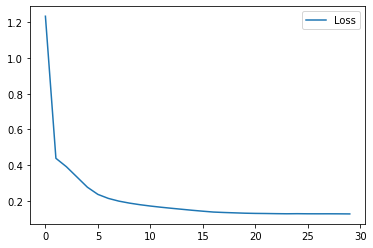

In [282]:
# plot history
plt.plot(history.history['loss'], label = 'Loss')
plt.legend()
plt.show()

#### Make Prediction

In [283]:
# make a prediction
y_test_pre = model.predict(x_test)
# check length
y_test_pre.shape, y_test.shape

63/63 [==============================] - 0s 687us/step


((1994, 1), (1994,))

In [284]:
x_test.shape

(1994, 1, 21)

#### Model Evaluation

In [285]:
y_test_pre

array([[1.9076979],
       [3.2067168],
       [2.3629673],
       ...,
       [2.158131 ],
       [3.154429 ],
       [2.1941009]], dtype=float32)

In [286]:
y_test_pre.shape

(1994, 1)

In [287]:
def RMSE(actual, prediction):
    rmse = np.sqrt(mean_squared_error(actual, prediction))
    return rmse

In [288]:
print(RMSE(y_test, y_test_pre))

0.34753370217804286


In [289]:
r2_score(y_test, y_test_pre)

0.6900144227647373